## PHẦN 1: CÀI ĐẶT, IMPORTS & THIẾT LẬP BAN ĐẦU

In [1]:
# ==============================================================================
# CELL 1.1: CÀI ĐẶT THƯ VIỆN & BIẾN MÔI TRƯỜNG (CẬP NHẬT)
# ==============================================================================
import os
import json
import asyncio
import operator
import time 
import re
from typing import TypedDict, Annotated, List, Dict, Any, Literal, Optional, Union

# Tải các biến môi trường
from dotenv import load_dotenv 
load_dotenv()

# LangChain & LangGraph
from langchain_core.messages import BaseMessage, HumanMessage   
from pydantic.v1 import BaseModel, Field, schema_json_of
# --- NÂNG CẤP: Chuyển sang thư viện Google Generative AI (dành cho AI Studio) ---
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages

# --- NÂNG CẤP: Thêm công cụ tìm kiếm ---
from langchain_community.tools.tavily_search import TavilySearchResults

# Thư viện hỗ trợ & Kho tri thức
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from rich.console import Console
from rich.markdown import Markdown
from rich.pretty import pprint
from IPython.display import Image, display

In [2]:
# ==============================================================================
# CELL 1.2: CẤU HÌNH LOG & CÁC HÀM IN ẤN
# ==============================================================================
from langchain_groq import ChatGroq
# --- CẤU HÌNH LOG ---
VERBOSE_MODE = True

# --- KHỞI TẠO CÁC CÔNG CỤ IN ẤN ---
console = Console()

def print_step(message: str):
    if VERBOSE_MODE:
        console.print(f"\n[bold cyan]>[/bold cyan] {message}")

def print_result(data: Any, title: str = "Kết quả"):
    if VERBOSE_MODE:
        console.print(f"[bold green]✔️ {title}:[/bold green]")
        pprint(data, expand_all=True)
        
def print_warning(message: str):
    if VERBOSE_MODE:
        console.print(f"[bold yellow]⚠️  {message}[/bold yellow]")

In [3]:
# ==============================================================================
# CELL 1.3: KHỞI TẠO LLM (NÂNG CẤP SANG GOOGLE AI STUDIO)
# ==============================================================================
try:
    llm = ChatGoogleGenerativeAI(
        model="gemini-2.5-flash", # Sử dụng model mới nhất và mạnh nhất
        temperature=0.1,
        google_api_key=os.getenv("GOOGLE_API_KEY")
    )
    print("✅ LLM (Gemini 2.5 Flash từ Google AI Studio) đã được khởi tạo thành công.")
except Exception as e:
    print(f"❌ LỖI: Không thể khởi tạo LLM. Hãy chắc chắn bạn đã cài 'langchain-google-genai' và có GOOGLE_API_KEY trong file .env. Lỗi: {e}")
    llm = None

✅ LLM (Gemini 2.5 Flash từ Google AI Studio) đã được khởi tạo thành công.


## PHẦN 2: ĐỊNH NGHĨA STATE CỦA HỆ THỐNG


In [4]:
# ==============================================================================
# CELL 1.4: TẢI KHO TRI THỨC (RAG)
# ==============================================================================
# --- TẢI KHO TRI THỨC ---
BASE_VECTOR_STORE_PATH = "vector_store"
vector_store = None
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

if os.path.exists(BASE_VECTOR_STORE_PATH):
    subdirectories = [f.path for f in os.scandir(BASE_VECTOR_STORE_PATH) if f.is_dir()]
    if not subdirectories:
        print(f"❌ LỖI: Không tìm thấy thư mục con nào trong '{BASE_VECTOR_STORE_PATH}'.")
    else:
        try:
            print_step(f"Đang tải và hợp nhất các kho tri thức từ {len(subdirectories)} thư mục...")
            # Tải kho tri thức đầu tiên để làm cơ sở
            first_store_path = subdirectories.pop(0)
            vector_store = FAISS.load_local(first_store_path, embeddings, allow_dangerous_deserialization=True)
            print(f"✅ Đã tải thành công kho tri thức cơ sở: '{os.path.basename(first_store_path)}'")

            # Hợp nhất các kho tri thức còn lại
            for store_path in subdirectories:
                if os.path.exists(os.path.join(store_path, "index.faiss")):
                    temp_store = FAISS.load_local(store_path, embeddings, allow_dangerous_deserialization=True)
                    vector_store.merge_from(temp_store)
                    print(f"✅ Đã hợp nhất thành công: '{os.path.basename(store_path)}'")
                else:
                    print_warning(f"Bỏ qua thư mục '{os.path.basename(store_path)}' vì không chứa file index.faiss.")
            
            print("\n[bold green]✔️ Tất cả các kho tri thức RAG đã được tải và hợp nhất thành công.[/bold green]")

        except Exception as e:
            print(f"❌ LỖI trong quá trình tải hoặc hợp nhất kho tri thức: {e}")
else:
    print(f"❌ LỖI: Không tìm thấy thư mục gốc của kho tri thức tại '{BASE_VECTOR_STORE_PATH}'.")


c:\Users\Hi\Documents\IAI - UET\AI-Lesson-Plan-Generator\plan_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


> Đang tải và hợp nhất các kho tri thức từ 2 thư mục...

✅ Đã tải thành công kho tri thức cơ sở: 'sgk_toan_12_1'
✅ Đã hợp nhất thành công: 'sgk_toan_9_1'

[bold green]✔️ Tất cả các kho tri thức RAG đã được tải và hợp nhất thành công.[/bold green]


In [5]:
# ==============================================================================
# CELL 1.5: KHỞI TẠO VÀ QUẢN LÝ TRÍ NHỚ DÀI HẠN (NÂNG CẤP V9.4)
# ==============================================================================
MEMORY_FILE_PATH = "long_term_memory.json"
memory_vector_store = None

# Hàm để tải trí nhớ từ file JSON
def load_memory():
    if not os.path.exists(MEMORY_FILE_PATH):
        return []
    with open(MEMORY_FILE_PATH, 'r', encoding='utf-8') as f:
        return json.load(f)

# Hàm để lưu một giáo án mới vào trí nhớ
def save_to_memory(request: str, structured_plan: Dict[str, Any]):
    memory = load_memory()
    memory.append({
        "request": request,
        "plan": structured_plan
    })
    with open(MEMORY_FILE_PATH, 'w', encoding='utf-8') as f:
        json.dump(memory, f, ensure_ascii=False, indent=2)
    print_step("🧠 Đã lưu giáo án thành công vào Trí nhớ Dài hạn.")

# Hàm để tạo một vector store từ trí nhớ (để tìm kiếm tương đồng)
def build_memory_vector_store():
    global memory_vector_store
    memory_content = load_memory()
    if not memory_content:
        print_warning("Trí nhớ trống, không có gì để xây dựng vector store.")
        return

    # Chỉ lấy phần 'request' để tìm kiếm
    texts = [item['request'] for item in memory_content]
    # Lưu toàn bộ item làm metadata
    metadatas = memory_content
    
    memory_vector_store = FAISS.from_texts(texts, embeddings, metadatas=metadatas)
    print_step("✅ Đã xây dựng Vector Store cho Trí nhớ Dài hạn.")

# Tự động xây dựng vector store khi khởi động notebook
build_memory_vector_store()

> ✅ Đã xây dựng Vector Store cho Trí nhớ Dài hạn.

In [6]:
# ==============================================================================
# CELL 2.1: ĐỊNH NGHĨA STATE NÂNG CAO (v9.0)
# ==============================================================================
from typing import TypedDict, Annotated, List, Dict, Any, Literal, Optional, Union
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
import operator

# --- Hàm tiện ích (giữ nguyên) ---
def merge_dicts(dict1: Dict[str, Any], dict2: Dict[str, Any]) -> Dict[str, Any]:
    merged = dict1.copy()
    for key, value in dict2.items():
        if key in merged and isinstance(merged[key], dict) and isinstance(value, dict):
            merged[key] = merge_dicts(merged[key], value)
        else:
            merged[key] = value
    return merged

# --- Cấu trúc dữ liệu con (giữ nguyên) ---
class DetailedTask(TypedDict):
    task_id: int
    task_name: str
    task_description: str
    estimated_duration: int 
    guidance: str
    status: Literal["pending", "completed"]

# === NÂNG CẤP V9.0: CÁC CẤU TRÚC DỮ LIỆU MỚI CHO TƯ DUY SÂU ===
class DifferentiatedInstruction(TypedDict):
    """Gợi ý cho việc dạy học phân hóa trong một hoạt động."""
    for_struggling_students: str
    for_advanced_students: str

class StructuredContentItem(TypedDict):
    """Định nghĩa một hoạt động hoặc đánh giá có cấu trúc."""
    task_id: int
    activity_name: str
    question_or_description: str # Gộp 'question' và 'description'
    duration_minutes: int
    content_type: str # Gộp 'activity_type' và 'question_type'
    teacher_actions: List[str]
    solution_guide: Any
    answer: Optional[str] # Dành cho câu hỏi đánh giá
    differentiation: Optional[DifferentiatedInstruction]

class FinalStructuredPlan(TypedDict):
    """Định nghĩa cấu trúc JSON cho giáo án cuối cùng."""
    general_info: Dict[str, Any]
    learning_objectives: List[str]
    preparation: Dict[str, List[str]]
    knowledge_summary: str
    lesson_flow: List[StructuredContentItem]
    # pedagogical_explainer: Dict[str, Any] # Dành cho nâng cấp tương lai

# === NÂNG CẤP V9.0: STATE MỚI VỚI CÁC TRƯỜNG TRÍ TUỆ MỚI ===
class TeacherStateV5(TypedDict):
    # Các trường cơ bản
    original_request: str
    messages: Annotated[List[BaseMessage], add_messages]
    domain: Optional[str]
    
    # === NÂNG CẤP: student_persona giờ sẽ chứa cả chiến lược phân hóa ===
    student_persona: Optional[Dict[str, Any]] 
    
    # Các bước tuần tự ban đầu
    analyzed_objective: Optional[Any]
    pedagogy_strategy: Optional[Any]
    pedagogical_blueprint: Optional[List[str]]

    # Các trường nâng cao
    expanded_queries: Optional[List[str]]
    task_list: Optional[List[DetailedTask]]
    current_task_id: Optional[int]
    current_task_retry_count: int  # <-- THÊM DÒNG NÀY VÀO ĐÂY
    reflection_notes: Optional[str]
    agent_outputs: Annotated[Dict[str, Any], merge_dicts] 
    next_agent: str
    
    # Các trường tạm thời cho vòng lặp kiểm duyệt vi mô (Micro-loop)
    current_content_to_validate: Optional[Dict[str, Any]]
    validation_feedback: Optional[str]

    inspirational_example: Optional[List[Dict[str, Any]]]

    # === NÂNG CẤP: Output cuối cùng sẽ có 2 dạng ===
    final_structured_plan: Optional[FinalStructuredPlan] # Dạng JSON có cấu trúc
    final_markdown_plan: Optional[str] # Dạng Markdown để hiển thị


print("✅ 'TeacherStateV5' (v9.0 - Hỗ trợ Phân hóa & Cấu trúc) đã được định nghĩa.")

✅ 'TeacherStateV5' (v9.0 - Hỗ trợ Phân hóa & Cấu trúc) đã được định nghĩa.


In [7]:
# ==============================================================================
# CELL 2.2: NODE KHỞI TẠO STATE
# ==============================================================================
def initialize_state_node(state: TeacherStateV5) -> Dict[str, Any]:
    """
    Node đầu tiên trong graph.
    Lấy yêu cầu gốc từ tin nhắn đầu vào và điền vào trường 'original_request'.
    """
    print_step("`Initializer`: Đang khởi tạo trạng thái và lấy yêu cầu gốc...")
    user_request = state['messages'][-1].content
    return {"original_request": user_request}

print("✅ Node khởi tạo 'initialize_state_node' đã được định nghĩa.")

✅ Node khởi tạo 'initialize_state_node' đã được định nghĩa.


## PHẦN 3: ĐỊNH NGHĨA CÁC AGENT

In [8]:
# ==============================================================================
# CELL 3.1: HÀM TIỆN ÍCH & CẤU TRÚC DỮ LIỆU (v9.7 - TƯ DUY LINH HOẠT)
# ==============================================================================
import json
from pydantic.v1 import BaseModel, Field, schema_json_of
from typing import List, Dict, Any, Literal, Optional

# --- Các hàm tiện ích giữ nguyên ---
def format_solution_guide(guide: Any) -> str:
    if not guide: return "Chưa có hướng dẫn."
    if isinstance(guide, str): return guide
    if isinstance(guide, list): return "\n".join(f"- {step}" for step in guide)
    if isinstance(guide, dict): return "\n".join(f"- {key.replace('_', ' ').title()}: {value}" for key, value in guide.items())
    return str(guide)

def format_teacher_actions(actions: Optional[List[str]]) -> str:
    if not actions: return "Giáo viên quan sát và hỗ trợ chung."
    return "\n".join(f"  - {action}" for action in actions)

def update_agent_outputs(state: "TeacherStateV5", key: str, value: Any) -> Dict[str, Any]:
    outputs = state.get("agent_outputs", {}).copy()
    if key not in outputs: outputs[key] = []
    outputs[key].append(value)
    return {"agent_outputs": outputs}

SYSTEM_PERSONA_PROMPT = "BẠN LÀ MỘT TRỢ LÝ AI CHUYÊN NGHIỆP, ĐÓNG VAI TRÒ MỘT GIÁO VIÊN GIÀU KINH NGHIỆM TẠI VIỆT NAM. LUÔN LUÔN trả lời bằng TIẾNG VIỆT."

# === CẬP NHẬT CẤU TRÚC HOẠT ĐỘNG LINH HOẠT ===
class DifferentiatedInstructionModel(BaseModel):
    for_struggling_students: str = Field(description="Gợi ý cụ thể cho nhóm học sinh yếu/gặp khó khăn.")
    for_advanced_students: str = Field(description="Gợi ý, thử thách hoặc hoạt động nâng cao cho nhóm học sinh giỏi.")

class LearningActivity(BaseModel):
    activity_name: str = Field(description="Tên của hoạt động học tập.")
    activity_type: str = Field(description="Phân loại hoạt động. Ví dụ: 'Thảo luận nhóm', 'Thực hành cá nhân'")
    duration_minutes: int = Field(description="Tổng thời gian ước tính (bằng SỐ PHÚT) cho cả hai phần.")
    teacher_actions: List[str] = Field(description="Danh sách các hành động CỤ THỂ của GIÁO VIÊN.")
    # Thay 'description' bằng cấu trúc Lõi/Mở rộng
    core_component: str = Field(description="Mô tả phần hoạt động CỐT LÕI mà TẤT CẢ học sinh cần hoàn thành.")
    extension_component: Optional[str] = Field(description="Mô tả phần hoạt động MỞ RỘNG dành cho học sinh làm nhanh hoặc nếu còn dư thời gian.")
    solution_guide: Optional[Any] = Field(description="Hướng dẫn giải hoặc các câu hỏi gợi mở.")
    differentiation: Optional[DifferentiatedInstructionModel] = Field(description="Gợi ý phân hóa cụ thể cho hoạt động này.")

class AssessmentItem(BaseModel):
    activity_name: str = Field(description="Tên của hoạt động đánh giá.")
    question_type: str = Field(description="Loại câu hỏi. Ví dụ: 'Tự luận', 'Trắc nghiệm'")
    duration_minutes: int = Field(description="Tổng thời gian ước tính (bằng SỐ PHÚT) cho cả hai phần.")
    teacher_actions: List[str] = Field(description="Danh sách các hành động CỤ THỂ của GIÁO VIÊN.")
    # Thay 'question' bằng cấu trúc Lõi/Mở rộng
    core_component: str = Field(description="Nội dung câu hỏi hoặc đề bài CỐT LÕI mà TẤT CẢ học sinh cần hoàn thành.")
    extension_component: Optional[str] = Field(description="Câu hỏi phụ hoặc thử thách MỞ RỘNG dành cho học sinh làm nhanh hoặc nếu còn dư thời gian.")
    answer: str = Field(description="Đáp án chính xác và ngắn gọn cho phần CỐT LÕI.")
    solution_guide: Any = Field(description="Hướng dẫn giải chi tiết từng bước.")
    differentiation: Optional[DifferentiatedInstructionModel] = Field(description="Gợi ý phân hóa cụ thể cho hoạt động này.")

# --- Các model khác giữ nguyên ---
class StudentPersona(BaseModel):
    learning_pace: Literal["nhanh", "trung bình", "chậm"] = Field(description="Tốc độ học tập chung của lớp.")
    engagement_style: Literal["chủ động", "thụ động", "hỗn hợp"] = Field(description="Mức độ tham gia chung của lớp.")
    special_notes: str = Field(description="Tóm tắt các đặc điểm nổi bật của lớp học.")

class StudentPersonaAndDifferentiation(StudentPersona):
    differentiation_strategy: DifferentiatedInstructionModel = Field(description="Chiến lược dạy học phân hóa tổng thể cho cả bài học dựa trên các đặc điểm của lớp.")

class DetailedTaskModel(BaseModel):
    task_name: str = Field(description="Tên của nhiệm vụ này.")
    task_description: str = Field(description="Mô tả chi tiết nhiệm vụ cần thực hiện.")
    estimated_duration: int = Field(description="Thời gian ước tính (bằng phút) cho nhiệm vụ này.")

class TaskListWithDuration(BaseModel):
    tasks: List[DetailedTaskModel]

class DetailedPedagogyChoice(BaseModel):
    name: str = Field(description="Tên của phương pháp sư phạm được chọn.")
    rationale: str = Field(description="Lý do tại sao phương pháp này phù hợp.")
    key_actions: List[str] = Field(description="Danh sách các hành động/hoạt động cốt lõi đặc trưng cho phương pháp này.")

class ValidationResult(BaseModel):
    is_valid: bool = Field(description="Nội dung có hợp lệ và chính xác về mặt chuyên môn không.")
    feedback: str = Field(description="Phản hồi chi tiết. Nếu không hợp lệ, hãy giải thích rõ ràng lỗi sai và gợi ý cách sửa.")

class Domain(BaseModel): domain: str = Field(description="Lĩnh vực học thuật chính của yêu cầu.")
class ExpandedQueries(BaseModel): queries: List[str]
class BestSnippets(BaseModel): best_snippets: List[str]
class ParsedObjective(BaseModel): action_verb: str; bloom_level: int; topic: str; grade_level: str; duration_minutes: Optional[int]
class TaskClassification(BaseModel): agent_category: Literal["activity_designer", "theory_synthesizer", "assessment_creator"]
class BlueprintStage(BaseModel): stage_name: str; stage_objective: str; stage_direction: str
class PedagogicalBlueprint(BaseModel): blueprint: List[BlueprintStage]

print("✅ Các cấu trúc dữ liệu Pydantic (v9.7 - Hoạt động Linh hoạt) đã được định nghĩa.")

✅ Các cấu trúc dữ liệu Pydantic (v9.7 - Hoạt động Linh hoạt) đã được định nghĩa.


In [9]:
# ==============================================================================
# CELL 3.2: AGENT PHÂN TÍCH YÊU CẦU BAN ĐẦU (NÂNG CẤP V9.0)
# ==============================================================================
async def objective_interpreter_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Objective Interpreter` (v7.5) đang phân tích mục tiêu...")
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHIỆM VỤ:** Đọc yêu cầu của người dùng và trích xuất các thông tin sau.\n**YÊU CẦU:** \"{state['original_request']}\"\n**CÁC TRƯỜNG CẦN TRÍCH XUẤT:** `action_verb`, `bloom_level` (SỐ NGUYÊN), `topic`, `grade_level`, `duration_minutes`.\n**CHỈ TRẢ VỀ JSON.**"
    structured_llm = llm.with_structured_output(ParsedObjective, method="json_mode")
    try:
        parsed_result = await structured_llm.ainvoke(prompt)
        analyzed_objective_dict = parsed_result.dict()
        analyzed_objective_dict['constraints'] = {'duration_minutes': parsed_result.duration_minutes}
        del analyzed_objective_dict['duration_minutes']
        print_result(analyzed_objective_dict, "Mục tiêu & Ràng buộc đã phân tích")
        return {"analyzed_objective": analyzed_objective_dict}
    except Exception as e:
        print_warning(f"Lỗi tại Objective Interpreter: {e}. Sử dụng mục tiêu mặc định.")
        return {"analyzed_objective": { "action_verb": "soạn", "bloom_level": 3, "topic": state['original_request'], "grade_level": "9", "constraints": {"duration_minutes": 90} }}

async def domain_classifier_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Domain Classifier` (v7.5) đang xác định lĩnh vực chuyên môn...")
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHIỆM VỤ:** Đọc yêu cầu của người dùng và xác định lĩnh vực học thuật chính.\n**YÊU CẦU:** \"{state['original_request']}\"\n**LĨNH VỰC CÓ THỂ CHỌN:** 'Toán học', 'Vật lý', 'Hóa học', 'Sinh học', 'Văn học', 'Lịch sử', 'Địa lý', 'Ngoại ngữ', 'Tin học'.\n**YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key `domain`."
    structured_llm = llm.with_structured_output(Domain, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        print_result(result.domain, "Lĩnh vực chuyên môn được xác định")
        return {"domain": result.domain}
    except Exception as e:
        print_warning(f"Lỗi tại Domain Classifier: {e}. Sử dụng lĩnh vực mặc định 'Toán học'.")
        return {"domain": "Toán học"}

# === NÂNG CẤP: Agent này giờ đây là một nhà tư vấn chiến lược ===
# === SỬA LỖI PARSING: Prompt được làm rõ ràng hơn về cấu trúc lồng nhau ===
async def differentiated_instruction_advisor_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Differentiated Instruction Advisor` (v9.1) đang phân tích và đề xuất chiến lược phân hóa...")
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một chuyên gia sư phạm, chuyên về dạy học phân hóa.
    **NHIỆM VỤ:** Phân tích mô tả về lớp học dưới đây và đề xuất một chiến lược dạy học phân hóa TỔNG THỂ cho cả buổi học.
    **YÊU CẦU CỦA GIÁO VIÊN:** "{state['original_request']}"
    
    **CÁC BƯỚC SUY LUẬN (BẮT BUỘC):**
    1.  **Phân tích Đặc điểm:** Dựa vào các từ khóa, hãy xác định `learning_pace`, `engagement_style`, và tóm tắt vào `special_notes`.
    2.  **Đề xuất Chiến lược Phân hóa:** Dựa trên phân tích trên, hãy điền vào đối tượng `differentiation_strategy`. Đây PHẢI là một đối tượng JSON có 2 trường sau:
        -   `for_struggling_students`: Một chiến lược cụ thể để **hỗ trợ** nhóm học sinh có thể gặp khó khăn. (Ví dụ: "Chia nhỏ nhiệm vụ, cung cấp phiếu bài tập có gợi ý công thức, cho phép thêm thời gian.")
        -   `for_advanced_students`: Một chiến lược cụ thể để **thử thách** nhóm học sinh khá giỏi. (Ví dụ: "Chuẩn bị các câu hỏi mở rộng 'Tại sao?' và 'Nếu... thì sao?', giao một bài toán ứng dụng thực tế nhỏ.")

    **YÊU CẦU ĐỊNH DẠNG:** BẮT BUỘC trả về một đối tượng JSON duy nhất tuân thủ schema `StudentPersonaAndDifferentiation`. Trường `differentiation_strategy` PHẢI là một object lồng vào bên trong.
    """
    structured_llm = llm.with_structured_output(StudentPersonaAndDifferentiation, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        print_result(result.dict(), "Hồ sơ lớp học và Chiến lược Phân hóa")
        return {"student_persona": result.dict()}
    except Exception as e:
        print_warning(f"Lỗi tại Differentiated Instruction Advisor: {e}. Sử dụng hồ sơ mặc định.")
        fallback_persona = {
            "learning_pace": "trung bình",
            "engagement_style": "hỗn hợp",
            "special_notes": "Không có ghi chú đặc biệt.",
            "differentiation_strategy": {
                "for_struggling_students": "Quan sát và hỗ trợ thêm khi cần thiết.",
                "for_advanced_students": "Khuyến khích các em tìm tòi thêm."
            }
        }
        return {"student_persona": fallback_persona}

print("✅ Các agent phân tích yêu cầu ban đầu (v9.0 - Hỗ trợ Phân hóa) đã sẵn sàng.")

✅ Các agent phân tích yêu cầu ban đầu (v9.0 - Hỗ trợ Phân hóa) đã sẵn sàng.


In [10]:
# ==============================================================================
# CELL 3.3: AGENT LẬP KẾ HOẠCH CHIẾN LƯỢC (v7.5)
# ==============================================================================
async def pedagogy_strategist_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Pedagogy Strategist` (v7.5) đang xây dựng chiến lược sư phạm chi tiết...")
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **MỤC TIÊU BÀI HỌC:** {state.get('analyzed_objective')}
    **HỒ SƠ LỚP HỌC:** {state.get('student_persona')}
    **NHIỆM VỤ:** Dựa vào mục tiêu và hồ sơ lớp học, hãy chọn MỘT phương pháp sư phạm phù hợp nhất. Sau đó, phân tích phương pháp đó thành các hành động cốt lõi.
    **VÍ DỤ:** Nếu chọn 'Dạy học theo dự án', key_actions có thể là ["Giao dự án", "Học sinh làm việc nhóm", "Báo cáo sản phẩm"].
    **YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với các key `name`, `rationale`, `key_actions`.
    """
    structured_llm = llm.with_structured_output(DetailedPedagogyChoice, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        print_result(result.dict(), "Chiến lược sư phạm chi tiết")
        return {"pedagogy_strategy": result.dict()}
    except Exception as e:
        print_warning(f"Lỗi tại Pedagogy Strategist: {e}. Sử dụng chiến lược mặc định.")
        return {"pedagogy_strategy": {"name": "Dạy học giải quyết vấn đề", "rationale": "Mặc định do lỗi.", "key_actions": ["Nêu vấn đề", "Học sinh tìm giải pháp", "Trình bày kết quả"]}}

async def pedagogical_architect_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Pedagogical Architect` (v9.4) đang thiết kế kịch bản buổi học...")
    
    inspirational_example = state.get("inspirational_example")
    example_prompt_part = ""
    if inspirational_example:
        example_prompt_part = f"""
        **VÍ DỤ THAM KHẢO (TỪ MỘT GIÁO ÁN THÀNH CÔNG TRƯỚC ĐÂY):**
        Đây là một luồng hoạt động đã được chứng minh là hiệu quả cho một chủ đề tương tự. Hãy học hỏi cấu trúc và cách tiếp cận từ nó:
        ```json
        {json.dumps(inspirational_example, ensure_ascii=False, indent=2)}
        ```
        """
    
    prompt = f"""{SYSTEM_PERSONA_PROMPT} Với vai trò là một chuyên gia thiết kế trải nghiệm học tập.
    **NHIỆM VỤ:** Xây dựng một "Bản thiết kế Sư phạm" - một kịch bản CẤP CAO cho buổi học.
    
    {example_prompt_part}
    **QUY TẮC:**
    1.  Tạo ra 3-5 giai đoạn chính cho dòng chảy của buổi học.
    2.  Mỗi giai đoạn phải có tên (`stage_name`), mục tiêu (`stage_objective`), và định hướng (`stage_direction`).
    3.  Đảm bảo độ khó tăng tiến qua các giai đoạn.
    **THÔNG TIN PHÂN TÍCH:**
    - Mục tiêu: {state.get('analyzed_objective')}
    - Hồ sơ lớp học: {state.get('student_persona')}
    - Chiến lược Sư phạm: {state.get('pedagogy_strategy')}
    **YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key là `blueprint`, giá trị là một danh sách các đối tượng Stage.
    """
    structured_llm = llm.with_structured_output(PedagogicalBlueprint, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        blueprint_list_of_strings = [f"{stage.stage_name}: {stage.stage_direction}" for stage in result.blueprint]
        print_result(blueprint_list_of_strings, "Bản thiết kế Sư phạm đã được tạo")
        return {"pedagogical_blueprint": blueprint_list_of_strings}
    except Exception as e:
        print_warning(f"Lỗi tại Pedagogical Architect: {e}. Sử dụng blueprint mặc định.")
        return {"pedagogical_blueprint": ["Giai đoạn 1: Giới thiệu bài học", "Giai đoạn 2: Luyện tập", "Giai đoạn 3: Đánh giá"]}

async def memory_retrieval_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Memory Retrieval` (v9.4) đang tìm kiếm trong trí nhớ...")
    
    if not memory_vector_store:
        print_warning("Không có Trí nhớ Dài hạn. Bỏ qua bước này.")
        return {"inspirational_example": None}

    user_request = state["original_request"]
    
    # Tìm kiếm 1 ví dụ tương đồng nhất trong trí nhớ
    try:
        results = memory_vector_store.similarity_search_with_score(user_request, k=1)
        if results and results[0][1] < 0.5: # Chỉ lấy nếu độ tương đồng cao (điểm score thấp là tốt)
            best_example = results[0][0].metadata
            print_result(best_example['request'], "Tìm thấy ví dụ tương đồng trong trí nhớ")
            # Chỉ trả về phần "lesson_flow" để làm ví dụ
            return {"inspirational_example": best_example['plan']['lesson_flow']}
        else:
            print_step("Không tìm thấy ví dụ nào đủ tương đồng trong trí nhớ.")
            return {"inspirational_example": None}
    except Exception as e:
        print_warning(f"Lỗi khi truy xuất trí nhớ: {e}")
        return {"inspirational_example": None}
    
print("✅ Các agent lập kế hoạch chiến lược đã sẵn sàng.")

✅ Các agent lập kế hoạch chiến lược đã sẵn sàng.


In [11]:
# ==============================================================================
# CELL 3.4: AGENT TRUY XUẤT VÀ TỔNG HỢP KIẾN THỨC (RAG) (v7.5)
# ==============================================================================
async def query_expansion_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Query Expansion` (v7.5) đang phân tích yêu cầu...")
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHIỆM VỤ:** Tạo ra các cụm từ tìm kiếm đa dạng bằng tiếng Việt để tìm tài liệu.\n**CHỦ ĐỀ:** \"{state.get('analyzed_objective', {}).get('topic', '')}\"\n**LĨNH VỰC:** {state.get('domain', 'Chung')}\n**YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key `queries`."
    structured_llm = llm.with_structured_output(ExpandedQueries, method="json_mode")
    try:
        response = await structured_llm.ainvoke(prompt)
        print_result(response.queries, "Các truy vấn tìm kiếm đã được mở rộng")
        return {"expanded_queries": response.queries}
    except Exception as e:
        print_warning(f"Lỗi tại Query Expansion: {e}. Sử dụng truy vấn gốc.")
        return {"expanded_queries": [state.get('analyzed_objective', {}).get('topic', '')]}

async def resource_scout_agent_v2(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Resource Scout` (v8.1 - Sửa lỗi) đang tìm kiếm và sàng lọc...")
    retriever = vector_store.as_retriever(search_kwargs={"k": 5})
    all_docs = []
    queries = state.get('expanded_queries', [state.get('analyzed_objective', {}).get('topic', '')])
    for query in queries:
        all_docs.extend(retriever.invoke(query))
    unique_docs_content = list({doc.page_content for doc in all_docs})[:8]
    print_step(f"Tìm thấy {len(all_docs)} tài liệu, sàng lọc còn {len(unique_docs_content)} đoạn văn bản độc nhất.")
    
    # --- Phần Re-ranker giữ nguyên ---
    rerank_prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHIỆM VỤ:** Đọc yêu cầu gốc và chọn ra 3-4 đoạn văn bản tiếng Việt phù hợp NHẤT từ danh sách dưới đây.\n**YÊU CẦU GỐC:** \"{state.get('original_request', '')}\"\n**DANH SÁCH TÀI LIỆU:** {json.dumps(unique_docs_content, ensure_ascii=False)}\n**YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key `best_snippets`."
    structured_llm_reranker = llm.with_structured_output(BestSnippets, method="json_mode")
    best_snippets_text = "\n\n---\n\n".join(unique_docs_content)
    try:
        reranked_result = await structured_llm_reranker.ainvoke(rerank_prompt)
        best_snippets_text = "\n\n---\n\n".join(reranked_result.best_snippets)
    except Exception as e:
        print_warning(f"Lỗi tại Re-ranker: {e}. Sử dụng tất cả tài liệu.")

    # === ĐẠI TU PROMPT TÓM TẮT ===
    summary_prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một giáo viên kinh nghiệm, có khả năng diễn giải các tài liệu khô khan thành một bài tóm tắt kiến thức cốt lõi vừa CHÍNH XÁC, vừa HẤP DẪN cho học sinh.

    **NHIỆM VỤ:** Dựa **CHỈ** vào các đoạn văn bản dưới đây, hãy viết một bản **TÓM TẮT KIẾN THỨC CỐT LÕI** về chủ đề "{state.get('analyzed_objective', {}).get('topic', '')}" để in vào cuối giáo án.

    **QUY TẮC VỀ PHONG CÁCH:**
    1.  **VĂN PHONG TỰ NHIÊN:** Hãy viết như thể bạn đang giải thích trực tiếp cho học sinh. Bắt đầu một cách tự nhiên, không cần các câu rào đón như "Với vai trò là một giáo viên...".
    2.  **TẬP TRUNG VÀO "ĐIỂM NHẤN":** Đừng chỉ liệt kê. Hãy cố gắng nhóm các ý, tìm ra những điểm quan trọng nhất và nhấn mạnh chúng. Sử dụng gạch đầu dòng, **in đậm** để làm nổi bật.
    3.  **CHÍNH XÁC TUYỆT ĐỐI:** Chỉ được phép sử dụng thông tin có trong các đoạn văn bản được cung cấp. Nếu thông tin về một phần nào đó (ví dụ: "đường tròn nội tiếp") không có, hãy ghi rõ là "Thông tin về phần này không có trong tài liệu tham khảo."

    **CÁC ĐOẠN VĂN BẢN ĐỂ TÓM TẮT:**
    ---
    {best_snippets_text}
    ---
    """

    summary = "Chưa có bản tóm tắt kiến thức."
    try:
        summary_response = await llm.ainvoke(summary_prompt)
        summary = summary_response.content
    except Exception as e:
        print_warning(f"Lỗi tại bước tóm tắt: {e}.")
        
    resource = {"source": "Sách giáo khoa (từ RAG - đã sàng lọc)", "summary": summary}
    print_result(resource, "Tài liệu RAG cuối cùng")
    return update_agent_outputs(state, "resources", resource)

print("✅ Các agent RAG đã sẵn sàng.")

✅ Các agent RAG đã sẵn sàng.


In [12]:
# ==============================================================================
# CELL 3.5: AGENT GIAO VIỆC & CHUYÊN MÔN (v12.7 - TƯ DUY PHẢN TƯ)
# ==============================================================================

# Plan Delegator giữ nguyên như phiên bản v12.6
class DetailedTaskWithGuidance(BaseModel):
    task_name: str = Field(description="Tên của nhiệm vụ này, phải phản ánh MỘT mục tiêu duy nhất.")
    task_description: str = Field(description="Mô tả chi tiết nhiệm vụ cần thực hiện.")
    estimated_duration: int = Field(description="Thời gian ước tính (bằng phút) cho nhiệm vụ này.")
    guidance: str = Field(description="Một chỉ dẫn sư phạm NGẮN GỌN và CỤ THỂ cho agent chuyên môn.")

class TaskListWithGuidance(BaseModel):
    tasks: List[DetailedTaskWithGuidance]

async def plan_delegator_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Headmaster Delegator` (v13.1 - Giao việc Thông minh) đang chỉ đạo...")
    blueprint = state.get('pedagogical_blueprint', [])
    total_duration = state.get('analyzed_objective', {}).get('constraints', {}).get('duration_minutes', 90)
    agent_outputs_history = state.get("agent_outputs", {})
    new_agent_outputs = {"resources": agent_outputs_history.get("resources", [])}
    
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một Hiệu trưởng cực kỳ kinh nghiệm, chuyên thiết kế các luồng hoạt động sư phạm.
    **NHIỆM VỤ:** Chuyển đổi "Bản thiết kế Sư phạm" cấp cao thành một danh sách các nhiệm vụ CÓ Ý NGHĨA và KHẢ THI.

    **THÔNG TIN BỐI CẢNH:**
    - Bản thiết kế: {json.dumps(blueprint, ensure_ascii=False, indent=2)}
    - Tổng thời gian: **{total_duration} phút.**

    **QUY TẮC TUYỆT ĐỐI PHẢI TUÂN THEO:**
    1.  **GOM NHÓM HOẠT ĐỘNG:** Tuyệt đối **KHÔNG** được tạo các nhiệm vụ vụn vặt dưới 10 phút. Hãy tạo ra khoảng **5-7 nhiệm vụ chính** cho toàn bộ buổi học.
    2.  **PHÂN BỔ THỜI GIAN HỢP LÝ:** `estimated_duration` của mỗi nhiệm vụ phải hợp lý (ví dụ: 10, 15, 20 phút) và tổng thời gian của tất cả các nhiệm vụ nên xấp xỉ {total_duration} phút.
    3.  **MỤC TIÊU RÕ RÀNG:** `task_name` và `task_description` phải mô tả một mục tiêu học tập rõ ràng.
    4.  **CHỈ DẪN NGẮN GỌN:** `guidance` phải là một mệnh lệnh ngắn gọn, tập trung vào kết quả đầu ra.

    **VÍ DỤ TỐT (Cho 90 phút):**
    - Task 1: Khởi động & Giới thiệu bài học (15 phút)
    - Task 2: Hoạt động nhóm khám phá lý thuyết (25 phút)
    - Task 3: Luyện tập có hướng dẫn (20 phút)
    - Task 4: Trình bày và thảo luận chung (15 phút)
    - Task 5: Đánh giá nhanh và tổng kết (15 phút)

    **YÊU CẦU ĐỊNH DẠNG:** Trả về JSON theo schema `TaskListWithGuidance`.
    """
    structured_llm = llm.with_structured_output(TaskListWithGuidance, method="json_mode")
    try:
        task_list_result = await structured_llm.ainvoke(prompt)
        tasks_with_status = [{"task_id": i, **t.dict(), "status": "pending"} for i, t in enumerate(task_list_result.tasks) if t]
        print_result(tasks_with_status, f"Đã tạo {len(tasks_with_status)} nhiệm vụ với chỉ dẫn chi tiết")
        return {"task_list": tasks_with_status, "reflection_notes": None, "agent_outputs": new_agent_outputs}
    except Exception as e:
        print_warning(f"Lỗi tại Headmaster Delegator: {e}. Tạo task mặc định.")
        fallback_task = { "task_id": 0, "task_name": "Hoạt động luyện tập", "task_description": "Học sinh thực hành bài tập.", "estimated_duration": 45, "guidance": "Chỉ cần 2 bài tập.", "status": "pending" }
        return {"task_list": [fallback_task], "reflection_notes": None, "agent_outputs": state.get("agent_outputs", {})}
    
async def specialist_agent_logic(state: "TeacherStateV5", agent_type: str, pydantic_model: type[BaseModel]) -> Dict[str, Any]:
    print_step(f"`Agent: {agent_type}` (v13.1 - Tư duy Phản tư) đang tạo nội dung...")
    task_to_run = next((t for t in state.get('task_list', []) if t['task_id'] == state.get('current_task_id')), None)
    if not task_to_run: return {"current_content_to_validate": {"error": "Không tìm thấy task hiện tại."}}

    feedback_prompt = ""
    # CHỈ kích hoạt chế độ sửa chữa khi có feedback VÀ đây là lần thử lại
    if state.get('validation_feedback') and state.get('current_task_retry_count', 0) > 0:
        feedback_prompt = f"""
    **🚨 CẢNH BÁO: BẢN NHÁP TRƯỚC BỊ YÊU CẦU SỬA ĐỔI! 🚨**
    Đây là lần sửa DUY NHẤT, vì vậy hãy làm cho đúng.
    **MỆNH LỆNH SỬA CHỮA TỪ CỐ VẤN:** "{state.get('validation_feedback', '')}"
    
    **QUY TRÌNH TƯ DUY BẮT BUỘC TRƯỚC KHI HÀNH ĐỘNG:**
    1.  **Phân tích Lỗi Sai:** Bản nháp trước đã sai ở đâu so với mệnh lệnh? (Ví dụ: "Tôi đã thêm phần `differentiation` trong khi cố vấn yêu cầu loại bỏ nó.")
    2.  **Lập Kế hoạch Sửa chữa:** Để tuân thủ tuyệt đối mệnh lệnh, tôi sẽ phải thay đổi những gì? (Ví dụ: "Tôi sẽ tạo ra một JSON mới, copy phần cốt lõi và đảm bảo rằng các trường `extension_component` và `differentiation` đều là `null`.")
    3.  **Tạo Nội dung Mới:** Dựa trên kế hoạch sửa chữa, tạo ra một JSON hoàn toàn mới. **TUYỆT ĐỐI KHÔNG SÁNG TẠO THÊM** ngoài mệnh lệnh.
    """
    
    duration = task_to_run.get('estimated_duration', 10)

    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một nhà thiết kế hoạt động học tập, một cỗ máy tuân thủ mệnh lệnh một cách tuyệt đối.

    {feedback_prompt}

    **MỆNH LỆNH GỐC (Chỉ tuân theo nếu không có CẢNH BÁO ở trên):**
    - Nhiệm-vụ: "{task_to_run.get('task_name', '')}"
    - Chỉ-dẫn: "{task_to_run.get('guidance', 'Không có chỉ dẫn cụ thể.')}"
    - Thời-gian-được-giao: **{duration} phút.**

    **=== QUY TẮC SỐNG CÒN ===**
    1.  **TUÂN THỦ THỜI GIAN TUYỆT ĐỐI:** `duration_minutes` trong JSON bạn trả về **PHẢI BẰNG CHÍNH XÁC** con số được giao: **{duration} phút**. Không được tự ý thay đổi dù chỉ 1 phút. Đây là mệnh lệnh quan trọng nhất.
    2.  **TỰ ĐIỀU CHỈNH NỘI DUNG:** Hãy tự điều chỉnh mức độ phức tạp của hoạt động (`core_component`, `teacher_actions`...) để nó khả thi trong khoảng thời gian **{duration} phút** đã cho. Nếu thời gian ngắn, hoạt động phải đơn giản. Nếu thời gian dài, hoạt động có thể phức tạp hơn.
    3.  **ƯU TIÊN MỆNH LỆNH SỬA CHỮA:** Nếu có cảnh báo sửa đổi, đó là ưu tiên số một.

    **YÊU CẦU ĐỊNH DẠNG:**
    Luôn trả về một JSON hoàn chỉnh và đúng cấu trúc, tuân thủ nghiêm ngặt các QUY TẮC SỐNG CÒN ở trên.
    **Cấu trúc JSON yêu cầu:**
    ```json
    {schema_json_of(pydantic_model, indent=2)}
    ```
    """

    structured_llm = llm.with_structured_output(pydantic_model, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        content_dict = result.dict()
        # Chuẩn hóa output để dễ dàng đưa vào lesson_flow
        if 'core_component' in content_dict: content_dict['question_or_description'] = content_dict.pop('core_component')
        if 'extension_component' in content_dict: pass # Giữ lại để có thể là null
        if 'activity_type' in content_dict: content_dict['content_type'] = content_dict.pop('activity_type')
        if 'question_type' in content_dict: content_dict['content_type'] = content_dict.pop('question_type')
        
        print_result(content_dict, f"Nội dung do {agent_type} tạo ra")
        return {"current_content_to_validate": content_dict, "validation_feedback": None}
    except Exception as e:
        print_warning(f"Lỗi tại {agent_type}: {e}.")
        return {"current_content_to_validate": {"error": str(e)}}

# (Các hàm gọi specialist_agent_logic như theory_synthesizer_agent... không cần thay đổi)
async def theory_synthesizer_agent(state: "TeacherStateV5"): return await specialist_agent_logic(state, "Theory Synthesizer", LearningActivity)
async def activity_designer_agent(state: "TeacherStateV5"): return await specialist_agent_logic(state, "Activity Designer", LearningActivity)
async def assessment_creator_agent(state: "TeacherStateV5"): return await specialist_agent_logic(state, "Assessment Creator", AssessmentItem)

In [13]:
# ==============================================================================
# CELL 3.6: AGENT CỐ VẤN VÀ TỔNG HỢP (v12.0 - HOÀN THIỆN)
# ==============================================================================

# Critic trở thành "Người bảo vệ Kế hoạch"
async def content_validator_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    """
    Phiên bản Critic "dễ tính".
    - Lần đầu tiên (retry_count = 0): Nó sẽ kiểm tra, nhưng có xu hướng cho qua và đưa ra gợi ý.
    - Lần thứ hai (retry_count > 0): Nó sẽ TỰ ĐỘNG DUYỆT mà không cần suy nghĩ.
    """
    print_step(f"`Agent: Easy-Going Critic` (v13.1) đang phân tích...")
    
    # Lấy số lần đã thử lại từ state
    retry_count = state.get("current_task_retry_count", 0)

    # QUY TẮC VÀNG: Nếu đây là lần làm lại, TỰ ĐỘNG DUYỆT!
    if retry_count > 0:
        print_step("✔️ CRITIC (Lần 2): Đã nhận bản sửa. Tự động duyệt để chốt kế hoạch!")
        return {"validation_feedback": None} # None = DUYỆT

    # Nếu đây là lần đầu tiên, nó sẽ thực hiện kiểm tra "qua loa"
    content = state.get('current_content_to_validate')
    task_list = state.get('task_list', [])
    current_task = next((t for t in task_list if t['task_id'] == state.get('current_task_id')), None)
    
    if not content or content.get("error") or not current_task:
        return {"validation_feedback": "Lỗi tạo nội dung."}

    estimated_duration = current_task.get('estimated_duration', 'N/A')

    # Prompt mới cho Critic "dễ tính"
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một Cố vấn Sư phạm "dễ tính" và thực tế. Mục tiêu của bạn là giúp hoàn thành giáo án, không phải tìm lỗi để từ chối.
    
    **BẢN NHÁP CẦN ĐÁNH GIÁ:**
    ```json
    {json.dumps(content, ensure_ascii=False, indent=2)}
    ```
    **THỜI GIAN CHO PHÉP:** **{estimated_duration} phút.**

    **QUY TRÌNH TƯ DUY "DỄ TÍNH":**
    1.  **Nhìn tổng thể:** Hoạt động này có quá lố không? Có, gần như lúc nào cũng vậy.
    2.  **Đưa ra quyết định:**
        -   **Nếu hoạt động CỰC KỲ phi lý (ví dụ: yêu cầu 30 phút trong 5 phút):** Hãy trả về `is_valid: false` và đưa ra MỘT gợi ý sửa chữa DUY NHẤT và rõ ràng. (Ví dụ: "Hoạt động này quá dài. Hãy bỏ hết phần `extension_component` và `differentiation` đi.")
        -   **Nếu hoạt động chỉ HƠI tham vọng (phổ biến nhất):** Hãy trả về `is_valid: true`. Trong `feedback`, hãy viết một lời khuyên mang tính xây dựng. (Ví dụ: "Hoạt động này rất hay nhưng hơi dài. Giáo viên có thể dạy nhanh hơn một chút ở phần này hoặc giảm bớt một ví dụ để kịp tiến độ.")
        -   **Nếu hoạt động hoàn hảo:** Trả về `is_valid: true` và `feedback: "Hoạt động này rất tốt và khả thi."`.

    **QUY TẮC:** Luôn có xu hướng chấp nhận (`is_valid: true`) trừ khi nó thực sự không thể cứu vãn.
    """
    
    structured_llm = llm.with_structured_output(ValidationResult, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        
        if result.is_valid:
            # Ngay cả khi hợp lệ, vẫn có thể có feedback mang tính xây dựng
            print_step(f"✔️ CRITIC (Lần 1): Nội dung được duyệt! (Góp ý: {result.feedback})")
            return {"validation_feedback": None} # None = DUYỆT
        else:
            # Đây là trường hợp duy nhất nó sẽ từ chối
            feedback_text = result.feedback.strip()
            print_warning(f"CRITIC (Lần 1) PHẢN BIỆN: {feedback_text}")
            return {"validation_feedback": feedback_text}
            
    except Exception as e:
        print_warning(f"Lỗi tại Critic: {e}. Yêu cầu làm lại.")
        return {"validation_feedback": "Lỗi Critic, hãy bỏ hết các phần không cần thiết."}



# Dán lại code đầy đủ của hai hàm trên
async def structured_plan_compiler_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Structured Plan Compiler` (v12.0) đang tổng hợp giáo án...")
    outputs = state.get('agent_outputs', {})
    objective = state.get('analyzed_objective', {})
    
    activities = outputs.get('activities', [])
    assessments = outputs.get('assessments', [])
    all_content_items = activities + assessments
    allowed_duration = objective.get('constraints', {}).get('duration_minutes', 90)

    if not all_content_items:
        return {"reflection_notes": "Kế hoạch thất bại, không có hoạt động nào được tạo ra."}

    total_duration = sum(item.get('duration_minutes', 0) for item in all_content_items)
    
    if not ((allowed_duration * 0.90) <= total_duration <= (allowed_duration + 10)):
        reflection = f"Kế hoạch thất bại. Tổng thời gian ({total_duration} phút) không hợp lệ. Lập kế hoạch lại."
        print_warning(f"CRITIC LỚN: {reflection}")
        # return {"reflection_notes": reflection}

    print_step("CRITIC LỚN: Kế hoạch hợp lệ! Bắt đầu tổng hợp JSON...")
    all_content_sorted = sorted(all_content_items, key=lambda x: x.get('task_id', float('inf')))
    
    persona = state.get('student_persona', {})
    strategy = state.get('pedagogy_strategy', {})
    resources = state.get('agent_outputs', {}).get('resources', [{}])[0]
    general_info = { "chủ đề": objective.get('topic', 'N/A'), "môn học": state.get('domain', 'N/A'), "lớp": objective.get('grade_level', 'N/A'), "thời lượng": f"{allowed_duration} phút", "phương pháp chủ đạo": strategy.get('name', 'Chưa xác định'), "đặc điểm lớp học": persona.get('special_notes', 'Tiêu chuẩn'), }
    learning_objectives = [ f"Học sinh có thể {objective.get('action_verb', 'vận dụng')} kiến thức về {objective.get('topic', 'N/A')}.", "Rèn luyện kỹ năng tư duy logic.", "Phát triển kỹ năng hợp tác." ]
    preparation = { "giáo viên": ["Bảng phụ", "máy chiếu", "phiếu học tập"], "học sinh": ["Sách giáo khoa", "vở ghi", "dụng cụ học tập"] }
    final_plan_obj: FinalStructuredPlan = { "general_info": general_info, "learning_objectives": learning_objectives, "preparation": preparation, "knowledge_summary": resources.get('summary', 'Chưa có tóm tắt.'), "lesson_flow": all_content_sorted, }
    return {"final_structured_plan": final_plan_obj, "reflection_notes": None}

async def markdown_presentation_node(state: "TeacherStateV5") -> Dict[str, str]:
    print_step("`Node: Pedagogical Editor` (v13.1) đang biên tập và tạo bản trình bày...")
    plan_json = state.get("final_structured_plan")
    if not isinstance(plan_json, dict): return {"final_markdown_plan": "Lỗi: Không tìm thấy giáo án."}
    
    # Xây dựng bản nháp chi tiết từ các hoạt động
    draft_parts = []
    lesson_flow = plan_json.get('lesson_flow', [])
    for i, activity in enumerate(lesson_flow):
        title = f"### Hoạt động {i+1}: {activity.get('activity_name')} ({activity.get('duration_minutes')} phút)"
        draft_parts.append(title)
        draft_parts.append(f"**Nhiệm vụ:**\n{activity.get('question_or_description', 'Không có mô tả.')}")
        
        if activity.get('differentiation'):
            diff = activity['differentiation']
            if diff and (diff.get('for_struggling_students') or diff.get('for_advanced_students')):
                 draft_parts.append(f"> **Gợi ý Phân hóa:**")
                 if diff.get('for_struggling_students'):
                    draft_parts.append(f"> - *Hỗ trợ (HS yếu):* {diff.get('for_struggling_students')}")
                 if diff.get('for_advanced_students'):
                    draft_parts.append(f"> - *Thử thách (HS giỏi):* {diff.get('for_advanced_students')}")
    
    draft_content_md = "\n\n".join(draft_parts)

    # Lấy các thông tin tổng quan khác
    info = plan_json.get('general_info', {})
    objectives = "\n".join(f"- {obj}" for obj in plan_json.get('learning_objectives', []))
    preparation = "\n".join(f"- **{key.title()}:** {', '.join(items)}" for key, items in plan_json.get('preparation', {}).items())
    summary = plan_json.get('knowledge_summary', 'Chưa có tóm tắt.')

    # Tạo prompt cho "Biên tập viên Sư phạm"
    finalizing_prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một **Biên tập viên Sư phạm** giàu kinh nghiệm.
    **NHIỆM VỤ:** Dựa vào các thông tin tổng quan và bản nháp các hoạt động dưới đây, hãy viết một **GIÁO ÁN HOÀN CHỈNH** dưới dạng Markdown.

    **QUY TẮC QUAN TRỌNG NHẤT:**
    1.  **VIẾT LỜI CHUYỂN:** Giữa các hoạt động, hãy viết một đoạn "Lời chuyển của giáo viên" ngắn gọn (được **in nghiêng** và bắt đầu bằng `GV:`) để tạo sự kết nối mượt mà.
    2.  **GIỮ NGUYÊN NỘI DUNG:** Giữ nguyên toàn bộ nội dung chi tiết của từng hoạt động đã được cung cấp.
    3.  **ĐỊNH DẠNG CHUYÊN NGHIỆP:** Trình bày giáo án một cách sạch sẽ, rõ ràng, có các đề mục lớn (I, II, III, IV, V).

    **I. THÔNG TIN CHUNG**
    - **Chủ Đề:** {info.get('chủ đề', 'N/A')}
    - **Môn Học:** {info.get('môn học', 'N/A')}
    - **Lớp:** {info.get('lớp', 'N/A')}
    - **Thời Lượng:** {info.get('thời lượng', 'N/A')}
    - **Phương Pháp Chủ Đạo:** {info.get('phương pháp chủ đạo', 'N/A')}
    - **Đặc Điểm Lớp Học:** {info.get('đặc điểm lớp học', 'N/A')}

    **II. MỤC TIÊU BÀI HỌC**
    {objectives}

    **III. CHUẨN BỊ**
    {preparation}

    **IV. TIẾN TRÌNH BÀI DẠY**
    ---
    {draft_content_md}
    ---
    
    **V. TÓM TẮT KIẾN THỨC CỐT LÕI**
    {summary}
    """
    
    try:
        final_lesson_plan_response = await llm.ainvoke(finalizing_prompt)
        final_md = final_lesson_plan_response.content
        print_step("✔️ Đã biên tập thành công giáo án cuối cùng với lời chuyển mượt mà.")
    except Exception as e:
        print_warning(f"Lỗi ở bước biên tập cuối cùng: {e}. Sẽ trả về bản nháp không có lời chuyển.")
        # Fallback về cách cũ nếu LLM lỗi
        final_md = "\n".join(md_parts) # Dùng lại md_parts đã build ở trên
        
    return {"final_markdown_plan": final_md}

print("✅ Agent Cố vấn và Tổng hợp (v12.0) đã sẵn sàng.")

✅ Agent Cố vấn và Tổng hợp (v12.0) đã sẵn sàng.


## PHẦN 4: XÂY DỰNG VÀ BIÊN DỊCH GRAPH

In [14]:
# ==============================================================================
# CELL 4.1: CÁC NODE TIỆN ÍCH & ĐIỀU PHỐI (v12.0 - HOÀN THIỆN)
# ==============================================================================
from typing import Literal, Dict, Any
import time

def delay_node(state: "TeacherStateV5"): time.sleep(1); return state

def mark_task_complete(state: "TeacherStateV5") -> Dict[str, Any]:
    task_list = state.get("task_list", [])
    current_task_id = state.get("current_task_id")
    if not task_list or current_task_id is None: return {}
    new_task_list = [t.copy() for t in task_list]
    for task in new_task_list:
        if task.get("task_id") == current_task_id:
            task["status"] = "completed"
            break
    return {"task_list": new_task_list, "current_task_id": None}
    
def task_router_node(state: "TeacherStateV5"):
    print_step("`Router`: Đang kiểm tra nhiệm vụ...")
    task_list = state.get("task_list", [])
    next_task = next((task for task in task_list if task.get("status") == "pending"), None)
    if next_task:
        print_step(f"Nhiệm vụ tiếp theo: '{next_task['task_name']}' (ID: {next_task['task_id']})")
        # <<< SỬA ĐỔI DÒNG DƯỚI ĐÂY >>>
        # Reset bộ đếm khi bắt đầu một task mới
        return {"current_task_id": next_task['task_id'], "current_task_retry_count": 0}
    else:
        print_step("Hết nhiệm vụ, chuyển sang node Compiler.")
        return {"current_task_id": None}

async def task_dispatcher_agent(state: "TeacherStateV5"):
    print_step("`Agent: Task Dispatcher` đang giao việc...")
    task_to_run = next((t for t in state['task_list'] if t['task_id'] == state['current_task_id']), None)
    if not task_to_run: return {"next_agent": "structured_plan_compiler"}
    task_description = task_to_run['task_description']
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**Nhiệm vụ:** Phân loại nhiệm vụ sau vào MỘT trong ba agent: 'activity_designer', 'theory_synthesizer', 'assessment_creator'."
    structured_llm = llm.with_structured_output(TaskClassification)
    try:
        classification_result = await structured_llm.ainvoke(prompt)
        next_agent = classification_result.agent_category
    except Exception:
        next_agent = "activity_designer"
    print_step(f"--- 🚚 `Dispatcher`: Giao nhiệm vụ cho `{next_agent}`.")
    return {"next_agent": next_agent}

def commit_validated_content_node(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Commiter`: Đang ghi nhận nội dung đã được xác thực...")
    agent_ran = state["next_agent"]
    content = state["current_content_to_validate"]
    content['task_id'] = state['current_task_id']
    key_to_update = "assessments" if agent_ran == "assessment_creator" else "activities"
    updated_outputs = update_agent_outputs(state, key_to_update, content)
    updated_outputs["current_content_to_validate"] = None
    updated_outputs["validation_feedback"] = None
    return updated_outputs

def save_to_memory_node(state: "TeacherStateV5"):
    if state.get("final_structured_plan"):
        save_to_memory(state["original_request"], state["final_structured_plan"])
    return {} 

print("✅ Các node tiện ích và điều phối (v12.0 - Hoàn thiện) đã sẵn sàng.")

✅ Các node tiện ích và điều phối (v12.0 - Hoàn thiện) đã sẵn sàng.


In [15]:
# ==============================================================================
# CELL 4.2: LOGIC ĐIỀU HƯỚNG CÓ ĐIỀU KIỆN (v12.8 - SỬA 1 LẦN DUY NHẤT)
# ==============================================================================

# === NÂNG CẤP DỨT ĐIỂM: LOGIC SỬA 1 LẦN DUY NHẤT ===
def route_after_guardian_critique(state: "TeacherStateV5") -> Literal["commit", "retry_content_creation", "skip_and_move_on"]:
    """
    Điều hướng sau khi Critic đưa ra phản hồi.
    - commit: Nội dung được duyệt.
    - retry_content_creation: Nội dung bị từ chối lần đầu, cho phép thử lại 1 lần duy nhất.
    - skip_and_move_on: (Ngã rẽ dự phòng) Nếu có lỗi xảy ra sau khi thử lại, bỏ qua nhiệm vụ.
    """
    if state.get("validation_feedback") is None:
        # Nếu không có feedback (đã được duyệt), thì commit.
        return "commit"
    
    retry_count = state.get("current_task_retry_count", 0)
    
    # Nếu đây là lần thất bại đầu tiên (retry_count = 0)
    if retry_count == 0:
        print_warning(f"ROUTER (Critic): Yêu cầu Agent chuyên môn sửa lại (1/1).")
        # Tăng bộ đếm và cho phép thử lại
        state['current_task_retry_count'] = 1
        return "retry_content_creation"
    # Nếu đây là lần thất bại thứ hai (không nên xảy ra với logic Critic mới, nhưng đây là phương án dự phòng)
    else:
        task_id = state.get('current_task_id', 'N/A')
        print_warning(f"ROUTER (Critic): THẤT BẠI LẦN 2 với nhiệm vụ ID '{task_id}'. Bỏ qua và chuyển sang nhiệm vụ tiếp theo.")
        return "skip_and_move_on"
    
def route_after_router(state: "TeacherStateV5") -> Literal["continue_executing", "compile_and_critique"]:
    if state.get("current_task_id") is None: 
        return "compile_and_critique"
    else: 
        return "continue_executing"

def route_after_compilation(state: "TeacherStateV5") -> Literal["finish", "replan"]:
    if state.get("reflection_notes"):
        print_step("ROUTER (Compilation): Phát hiện phản hồi từ Critic lớn. Yêu cầu hệ thống lập kế hoạch lại.")
        return "replan"
    else:
        print_step("ROUTER (Compilation): Critic lớn đã hài lòng. Kết thúc quy trình.")
        return "finish"

print("✅ Các hàm logic điều hướng (v12.8 - Sửa 1 lần duy nhất) đã được định nghĩa.")

✅ Các hàm logic điều hướng (v12.8 - Sửa 1 lần duy nhất) đã được định nghĩa.


In [16]:
# ==============================================================================
# CELL 4.3: LẮP RÁP VÀ BIÊN DỊCH GRAPH (v12.8 - SỬA 1 LẦN DUY NHẤT)
# ==============================================================================
workflow = StateGraph(TeacherStateV5)

# 1. Thêm tất cả các node cần thiết vào graph
# Luồng Phân tích & Lập kế hoạch
workflow.add_node("initializer", initialize_state_node)
workflow.add_node("memory_retrieval", memory_retrieval_agent)
workflow.add_node("objective_interpreter", objective_interpreter_agent)
workflow.add_node("domain_classifier", domain_classifier_agent)
workflow.add_node("differentiated_instruction_advisor", differentiated_instruction_advisor_agent) 
workflow.add_node("pedagogy_strategist", pedagogy_strategist_agent)
workflow.add_node("pedagogical_architect", pedagogical_architect_agent)
workflow.add_node("query_expansion", query_expansion_agent)
workflow.add_node("resource_scout", resource_scout_agent_v2)
workflow.add_node("plan_delegator", plan_delegator_agent)

# Luồng Thực thi & Phản biện
workflow.add_node("task_router", task_router_node)
workflow.add_node("task_dispatcher", task_dispatcher_agent)
workflow.add_node("theory_synthesizer", theory_synthesizer_agent)
workflow.add_node("activity_designer", activity_designer_agent)
workflow.add_node("assessment_creator", assessment_creator_agent)
workflow.add_node("content_validator", content_validator_agent)
workflow.add_node("commit_validated_content", commit_validated_content_node)
workflow.add_node("mark_task_complete", mark_task_complete)

# Luồng Tổng hợp & Kết thúc
workflow.add_node("structured_plan_compiler", structured_plan_compiler_agent) 
workflow.add_node("markdown_presenter", markdown_presentation_node)
workflow.add_node("save_to_memory", save_to_memory_node)
workflow.add_node("delay_node", delay_node)

# 2. Thiết lập các kết nối (edges)
# --- Luồng Phân tích & Lập kế hoạch ban đầu ---
workflow.set_entry_point("initializer")
workflow.add_edge("initializer", "memory_retrieval")
workflow.add_edge("memory_retrieval", "objective_interpreter")
workflow.add_edge("objective_interpreter", "domain_classifier")
workflow.add_edge("domain_classifier", "differentiated_instruction_advisor")
workflow.add_edge("differentiated_instruction_advisor", "pedagogy_strategist")
workflow.add_edge("pedagogy_strategist", "pedagogical_architect")
workflow.add_edge("pedagogical_architect", "query_expansion")
workflow.add_edge("query_expansion", "resource_scout")
workflow.add_edge("resource_scout", "plan_delegator")

# Bắt đầu vòng lặp thực thi
workflow.add_edge("plan_delegator", "task_router")

# --- Vòng lặp Thực thi Nhiệm vụ ---
workflow.add_conditional_edges(
    "task_router", 
    route_after_router, 
    { "continue_executing": "task_dispatcher", "compile_and_critique": "structured_plan_compiler" }
)
workflow.add_conditional_edges(
    "task_dispatcher", 
    lambda state: state["next_agent"], 
    { "activity_designer": "activity_designer", "assessment_creator": "assessment_creator", "theory_synthesizer": "theory_synthesizer" }
)

workflow.add_edge("theory_synthesizer", "content_validator")
workflow.add_edge("activity_designer", "content_validator")
workflow.add_edge("assessment_creator", "content_validator")

# === NÂNG CẤP DỨT ĐIỂM: THÊM NGÃ RẼ MỚI "SKIP_AND_MOVE_ON" ===
# Logic điều hướng mới với 3 ngã rẽ:
# 1. "commit": Nếu tốt -> Ghi nhận.
# 2. "retry_content_creation": Nếu sai lần đầu -> Thử lại.
# 3. "skip_and_move_on": Nếu sai lần hai -> Nối thẳng đến "mark_task_complete" để bỏ qua.
workflow.add_conditional_edges(
    "content_validator",
    route_after_guardian_critique,
    {
        "commit": "commit_validated_content",
        "retry_content_creation": "task_dispatcher",
        "move_on": "mark_task_complete" # Nối dây mới!
    }
)
# === KẾT THÚC PHẦN THAY ĐỔI ===

workflow.add_edge("commit_validated_content", "mark_task_complete")
workflow.add_edge("mark_task_complete", "delay_node")
workflow.add_edge("delay_node", "task_router")

# --- Luồng Kết thúc ---
workflow.add_conditional_edges(
    "structured_plan_compiler", 
    route_after_compilation,
    { "replan": "plan_delegator", "finish": "markdown_presenter" }
)
workflow.add_edge("markdown_presenter", "save_to_memory")
workflow.add_edge("save_to_memory", END)

# Biên dịch graph hoàn chỉnh
app = workflow.compile()
print("✅ Graph đã được biên dịch thành công với logic 'Sửa 1 lần & Bỏ qua' (v12.8).")

✅ Graph đã được biên dịch thành công với logic 'Sửa 1 lần & Bỏ qua' (v12.8).


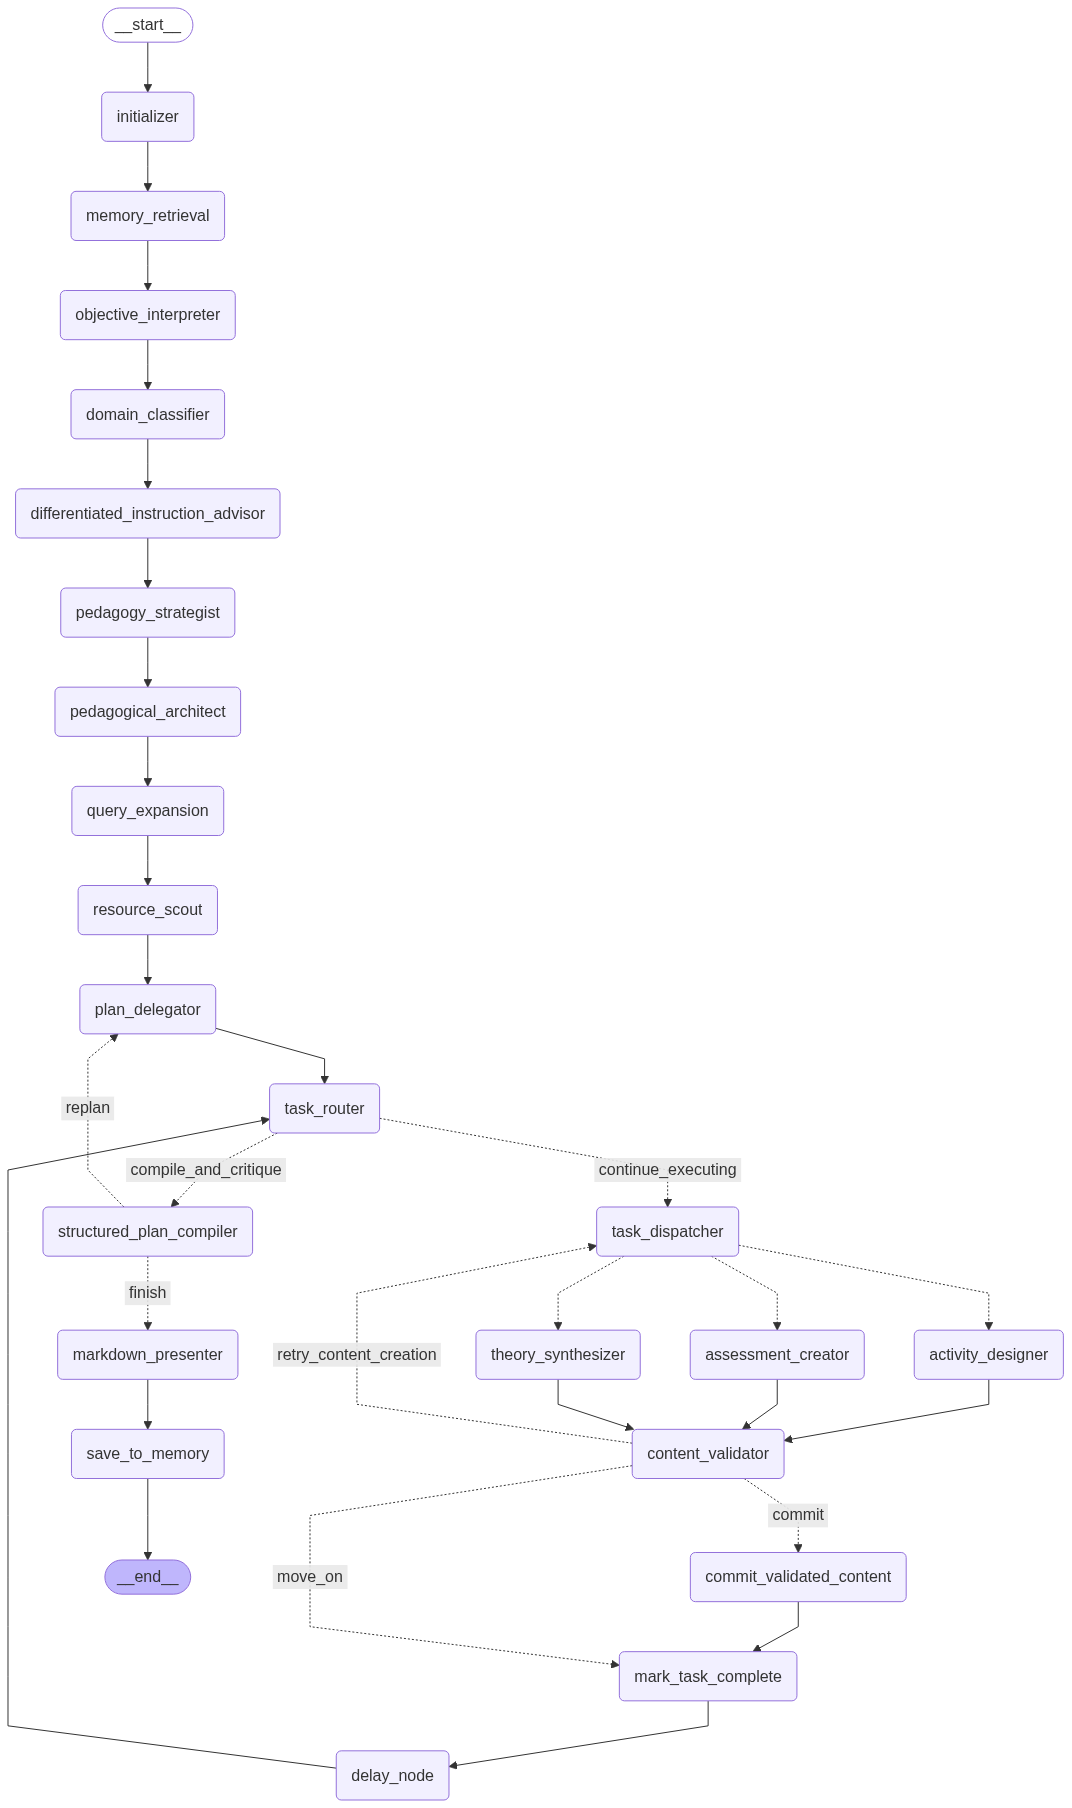

In [17]:
# ==============================================================================
# CELL 4.4: HIỂN THỊ SƠ ĐỒ GRAPH (TÙY CHỌN)
# ==============================================================================
try:
    # Lệnh này sẽ vẽ một sơ đồ của workflow, rất hữu ích để gỡ lỗi
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Lỗi vẽ biểu đồ: {e}. Đây là lỗi không nghiêm trọng, bạn vẫn có thể chạy quy trình.")

## PHẦN 5

In [18]:
# ==============================================================================
# CELL 5.1: ĐỊNH NGHĨA HÀM CHẠY QUY TRÌNH (v12.0 - HOÀN THIỆN)
# ==============================================================================
async def run_architect(user_request: str):
    if 'llm' not in globals() or llm is None:
        print_warning("LLM chưa được khởi tạo.")
        return
    if 'vector_store' not in globals() or vector_store is None:
        print_warning("Kho tri thức chưa được tải.")
        return
    if 'app' not in globals():
        print_warning("Graph 'app' chưa được biên dịch.")
        return

    initial_state = {"messages": [HumanMessage(content=user_request)]}
    console.print(f"\n[bold magenta]🚀 BẮT ĐẦU QUY TRÌNH V12.0 (HOÀN THIỆN) VỚI YÊU CẦU:[/bold magenta]\n> {user_request}")
    config = {"recursion_limit": 150} 
    
    final_markdown_plan = None
    final_structured_plan = None
    
    try:
        async for event in app.astream(initial_state, config=config):
            for node_name, node_output in event.items():
                console.print(f"\n[bold yellow]------- Hoàn thành bước: {node_name} -------[/bold yellow]")
                if node_name == "markdown_presenter":
                    final_markdown_plan = node_output.get("final_markdown_plan")
                    final_structured_plan = node_output.get("final_structured_plan")

        console.print("\n[bold magenta]🏁 KẾT THÚC QUY TRÌNH.[/bold magenta]")
        
        if final_markdown_plan:
            console.print("\n[bold green]📝 GIÁO ÁN HOÀN CHỈNH (v12.0)[/bold green]")
            console.print(Markdown(final_markdown_plan))
            
            if VERBOSE_MODE and final_structured_plan:
                print_result(final_structured_plan, "Output JSON có cấu trúc")
        else:
            print_warning("Không tạo được giáo án cuối cùng. Vui lòng kiểm tra log để gỡ lỗi.")
            
    except Exception as e:
        print_warning(f"Đã xảy ra lỗi nghiêm trọng trong quá trình chạy graph: {e}")
        import traceback
        traceback.print_exc()

print("✅ Hàm `run_architect` (v12.0) đã sẵn sàng để sử dụng.")

✅ Hàm `run_architect` (v12.0) đã sẵn sàng để sử dụng.


In [19]:
# ==============================================================================
# CELL 5.2: KÍCH HOẠT CHẠY THỬ NGHIỆM
# ==============================================================================
# Yêu cầu để kiểm tra
architect_request = "Soạn giúp tôi giáo án bài 'VỊ TRÍ TƯƠNG ĐỐI CỦA ĐƯỜNG THẲNG VÀ ĐƯỜNG TRÒN' cho học sinh lớp 9 trong 90 phút. Đây là một lớp học khá yếu, các em thường mất tập trung và cần các hoạt động có tính tương tác cao."
VERBOSE_MODE = True 

# Chạy quy trình đã được cải cách
# Lưu ý: bạn cần một môi trường hỗ trợ `await` ở cấp độ cao nhất (như Jupyter Notebook)
await run_architect(architect_request)

🚀 BẮT ĐẦU QUY TRÌNH V12.0 (HOÀN THIỆN) VỚI YÊU CẦU:
> Soạn giúp tôi giáo án bài 'VỊ TRÍ TƯƠNG ĐỐI CỦA ĐƯỜNG THẲNG VÀ ĐƯỜNG TRÒN' cho học sinh lớp 9 trong 90 phút. Đây 
là một lớp học khá yếu, các em thường mất tập trung và cần các hoạt động có tính tương tác cao.

> `Initializer`: Đang khởi tạo trạng thái và lấy yêu cầu gốc...

------- Hoàn thành bước: initializer -------

> `Agent: Memory Retrieval` (v9.4) đang tìm kiếm trong trí nhớ...

✔️ Tìm thấy ví dụ tương đồng trong trí nhớ:

"Soạn giúp tôi giáo án bài 'Đường tròn ngoại tiếp và đường tròn nội tiếp' cho học sinh lớp 9 trong 90 phút. Đây là một lớp học khá yếu, các em thường mất tập trung và cần các hoạt động có tính tương tác cao."

------- Hoàn thành bước: memory_retrieval -------

> `Agent: Objective Interpreter` (v7.5) đang phân tích mục tiêu...

✔️ Mục tiêu & Ràng buộc đã phân tích:

{
│   'action_verb': 'Soạn',
│   'bloom_level': 2,
│   'topic': 'VỊ TRÍ TƯƠNG ĐỐI CỦA ĐƯỜNG THẲNG VÀ ĐƯỜNG TRÒN',
│   'grade_level': 'Lớp 9',
│   'constraints': {
│   │   'duration_minutes': 90
│   }
}

------- Hoàn thành bước: objective_interpreter -------

> `Agent: Domain Classifier` (v7.5) đang xác định lĩnh vực chuyên môn...

✔️ Lĩnh vực chuyên môn được xác định:

'Toán học'

------- Hoàn thành bước: domain_classifier -------

> `Agent: Differentiated Instruction Advisor` (v9.1) đang phân tích và đề xuất chiến lược phân hóa...

✔️ Hồ sơ lớp học và Chiến lược Phân hóa:

{
│   'learning_pace': 'chậm',
│   'engagement_style': 'thụ động',
│   'special_notes': 'Lớp học có nền tảng kiến thức khá yếu, học sinh dễ mất tập trung và cần các hoạt động tương tác cao để duy trì sự chú ý và hứng thú.',
│   'differentiation_strategy': {
│   │   'for_struggling_students': 'Chia nhỏ kiến thức thành các phần nhỏ, sử dụng nhiều ví dụ trực quan, hình ảnh minh họa và vật thật. Tổ chức các hoạt động nhóm nhỏ, có sự hướng dẫn sát sao của giáo viên. Cung cấp phiếu bài tập có gợi ý, công thức hoặc bài tập điền khuyết. Thường xuyên kiểm tra nhanh để đảm bảo học sinh theo kịp bài.',
│   │   'for_advanced_students': 'Giao các bài tập nâng cao, yêu cầu chứng minh hoặc giải thích sâu hơn về các trường hợp đặc biệt. Khuyến khích học sinh tìm hiểu ứng dụng thực tế của vị trí tương đối đường thẳng và đường tròn (ví dụ: trong kiến trúc, kỹ thuật). Yêu cầu các em hỗ trợ, hướng dẫn các bạn yếu hơn trong nhóm.'
│   }
}

------- Hoàn thành bước: differentiated_instruction_advisor -------

> `Agent: Pedagogy Strategist` (v7.5) đang xây dựng chiến lược sư phạm chi tiết...

✔️ Chiến lược sư phạm chi tiết:

{
│   'name': 'Dạy học theo góc (Learning Stations)',
│   'rationale': 'Phương pháp Dạy học theo góc rất phù hợp với lớp học có nền tảng kiến thức yếu, học sinh dễ mất tập trung và có nhịp độ học chậm. Nó cho phép chia nhỏ kiến thức về vị trí tương đối của đường thẳng và đường tròn thành các hoạt động cụ thể, đa dạng tại mỗi góc, giúp học sinh tiếp cận từng phần một cách dễ dàng và không bị quá tải. Các hoạt động tương tác cao tại mỗi góc (sử dụng vật thật, hình ảnh, bài tập nhóm) sẽ duy trì sự chú ý và hứng thú của học sinh, chuyển từ trạng thái thụ động sang chủ động. Giáo viên có thể dễ dàng áp dụng chiến lược phân hóa bằng cách thiết kế các góc với mức độ khó khác nhau hoặc cung cấp tài liệu hỗ trợ đa dạng, đồng thời có thể quan sát, hỗ trợ sát sao từng nhóm nhỏ, đảm bảo không học sinh nào bị bỏ lại phía sau trong suốt 90 phút của bài học.',
│   'key_actions': [
│   │   'Thiết lập các góc học tập đa dạng với các nhiệm vụ khác nhau liên quan đến vị trí tương đối của đường thẳng và đường tròn (ví dụ: góc khám phá bằng vật thật, góc bài tập thực hành, góc ứng dụng thực tế).',
│   │   'Giới thiệu mục tiêu bài học, hướng dẫn rõ ràng về nhiệm vụ tại mỗi góc và quy trình luân chuyển giữa các góc cho học sinh.',
│   │   'Chia học sinh thành các nhóm nhỏ, hướng dẫn các nhóm bắt đầu làm việc tại góc đầu tiên.',
│   │   'Học sinh luân phiên di chuyển và thực hiện các hoạt động tương tác, khám phá, giải quyết vấn đề tại từng góc học tập theo thời gian quy định.',
│   │   'Giáo viên di chuyển giữa các góc, quan sát, hỗ trợ, giải đáp thắc mắc và kiểm tra nhanh sự hiểu bài của từng nhóm học sinh.',
│   │   'Tổ chức hoạt động tổng kết chung cả lớp, yêu cầu các nhóm chia sẻ kết quả, thảo luận, củng cố kiến thức trọng tâm và giải đáp các vấn đề còn lại.'
│   ]
}

------- Hoàn thành bước: pedagogy_strategist -------

> `Agent: Pedagogical Architect` (v9.4) đang thiết kế kịch bản buổi học...

✔️ Bản thiết kế Sư phạm đã được tạo:

[
│   'Khởi động và Giới thiệu bài học: Giáo viên sử dụng một vật thật (ví dụ: một chiếc vòng tay/vòng tròn và một cây bút/thước thẳng) hoặc hình ảnh/video minh họa các tình huống đường thẳng và đường tròn cắt nhau, tiếp xúc, không giao nhau trong thực tế. Đặt câu hỏi gợi mở để học sinh quan sát và mô tả các trường hợp có thể xảy ra. Sau đó, giới thiệu mục tiêu bài học và cách thức học theo góc, nhấn mạnh lợi ích của việc học chủ động.',
│   'Khám phá kiến thức tại các Góc học tập: Chia lớp thành 3 nhóm nhỏ (3-4 học sinh/nhóm). Mỗi nhóm sẽ luân chuyển qua 3 góc học tập đã được chuẩn bị sẵn, mỗi góc khoảng 20 phút, có 5 phút chuyển tiếp giữa các góc. Giáo viên di chuyển giữa các góc để quan sát, hỗ trợ, đặt câu hỏi gợi mở và kiểm tra nhanh sự hiểu bài của từng nhóm.\n\n*   **Góc 1: "Thực hành & Quan sát"**: Học sinh sử dụng vật thật (vòng tròn, thước thẳng, compa, dây) hoặc phần mềm hình học động (Geogebra) để tự tay tạo ra và quan sát các vị trí tương đối của đường thẳng và đường tròn. Nhiệm vụ: Đo đạc khoảng cách từ tâm đến đường thẳng (d) và bán kính (R) trong từng trường hợp, ghi lại kết quả và nhận xét mối quan hệ giữa d và R.\n*   **Góc 2: "Phân tích & Khái quát"**: Cung cấp các hình vẽ minh họa chi tiết và phiếu bài tập điền khuyết. Học sinh phân tích các trường hợp, điền vào chỗ trống các khái niệm, định nghĩa và điều kiện về d và R cho từng vị trí tương đối (cắt nhau, tiếp xúc, không giao nhau). Nhiệm vụ: Hoàn thành phiếu bài tập, tóm tắt kiến thức cốt lõi của mỗi vị trí.\n*   **Góc 3: "Bài tập & Vận dụng nhỏ"**: Cung cấp các bài tập trắc nghiệm hoặc tự luận ngắn, đơn giản để học sinh áp dụng ngay kiến thức vừa học. Ví dụ: Cho d và R, xác định vị trí tương đối; hoặc ngược lại. Nhiệm vụ: Giải các bài tập, thảo luận và kiểm tra chéo đáp án trong nhóm, chuẩn bị trình bày một bài tập tiêu biểu.',
│   'Tổng kết và Củng cố kiến thức: Giáo viên mời đại diện 1-2 nhóm chia sẻ nhanh những điều đã học được hoặc một bài tập tiêu biểu đã giải ở mỗi góc. Giáo viên tổng hợp, chốt lại các kiến thức trọng tâm về ba vị trí tương đối (cắt nhau, tiếp xúc, không giao nhau) và mối quan hệ d với R bằng sơ đồ tư duy hoặc bảng tổng hợp trên bảng. Giải đáp các câu hỏi chung của cả lớp, làm rõ những điểm học sinh còn băn khoăn.',
│   'Vận dụng và Mở rộng: Giáo viên đưa ra một tình huống thực tế hoặc một bài toán nhỏ có tính ứng dụng (ví dụ: thiết kế bánh răng, vị trí vệ tinh so với Trái Đất, xác định vùng phủ sóng) để học sinh suy nghĩ về ứng dụng của bài học. Giao bài tập về nhà, khuyến khích học sinh tìm thêm các ví dụ thực tế về vị trí tương đối của đường thẳng và đường tròn trong cuộc sống hàng ngày và chuẩn bị cho bài học tiếp theo.'
]

------- Hoàn thành bước: pedagogical_architect -------

> `Agent: Query Expansion` (v7.5) đang phân tích yêu cầu...

✔️ Các truy vấn tìm kiếm đã được mở rộng:

[
│   'Vị trí tương đối của đường thẳng và đường tròn',
│   'Lý thuyết vị trí tương đối đường thẳng và đường tròn',
│   'Bài tập vị trí tương đối đường thẳng và đường tròn có lời giải',
│   'Công thức xác định vị trí tương đối đường thẳng và đường tròn',
│   'Các trường hợp vị trí tương đối của đường thẳng và đường tròn',
│   'Chuyên đề vị trí tương đối đường thẳng và đường tròn lớp 9',
│   'Ví dụ minh họa vị trí tương đối đường thẳng và đường tròn',
│   'Tài liệu ôn tập vị trí tương đối đường thẳng và đường tròn',
│   'Trắc nghiệm vị trí tương đối đường thẳng và đường tròn',
│   'Phương pháp giải bài tập vị trí tương đối đường thẳng và đường tròn'
]

------- Hoàn thành bước: query_expansion -------

> `Agent: Resource Scout` (v8.1 - Sửa lỗi) đang tìm kiếm và sàng lọc...

> Tìm thấy 50 tài liệu, sàng lọc còn 8 đoạn văn bản độc nhất.

✔️ Tài liệu RAG cuối cùng:

{
│   'source': 'Sách giáo khoa (từ RAG - đã sàng lọc)',
│   'summary': 'Chào các em học sinh thân mến!\n\nHôm nay, thầy trò chúng ta sẽ cùng nhau "giải mã" một chủ đề rất thú vị và quan trọng trong hình học, đó là **VỊ TRÍ TƯƠNG ĐỐI CỦA ĐƯỜNG THẲNG VÀ ĐƯỜNG TRÒN**. Nghe có vẻ khô khan, nhưng thực ra nó rất gần gũi với những gì chúng ta thấy hàng ngày đấy! Hãy tưởng tượng một đường thẳng và một đường tròn "gặp nhau" thì có thể có những kiểu "gặp gỡ" nào nhé.\n\nDưới đây là những kiến thức cốt lõi mà các em cần nắm vững:\n\n---\n\n### **TÓM TẮT KIẾN THỨC CỐT LÕI: VỊ TRÍ TƯƠNG ĐỐI CỦA ĐƯỜNG THẲNG VÀ ĐƯỜNG TRÒN**\n\nKhi một đường thẳng và một đường tròn "gặp nhau" trên mặt phẳng, chúng ta có thể phân loại thành 3 trường hợp chính dựa trên số điểm chung của chúng:\n\n1.  **Đường thẳng và đường tròn CẮT NHAU:**\n    *   Đây là trường hợp chúng có **đúng hai điểm chung**.\n    *   Để nhận biết, chúng ta chỉ cần so sánh **khoảng cách (d)** từ tâm đường tròn đến đường thẳng với **bán kính (R)** của đường tròn. Nếu **d < R** thì chắc chắn chúng cắt nhau.\n\n2.  **Đường thẳng và đường tròn TIẾP XÚC VỚI NHAU:**\n    *   Trường hợp này đặc biệt hơn, chúng chỉ có **đúng một điểm chung**.\n    *   Điểm chung duy nhất này được gọi là **tiếp điểm**.\n    *   Khi đó, đường thẳng được gọi là **tiếp tuyến** của đường tròn tại tiếp điểm đó.\n    *   Dấu hiệu nhận biết: Khi **d = R** (khoảng cách từ tâm đến đường thẳng bằng bán kính), chúng sẽ tiếp xúc với nhau.\n\n3.  **Đường thẳng và đường tròn KHÔNG GIAO NHAU:**\n    *   Đúng như tên gọi, trong trường hợp này, chúng **không có bất kỳ điểm chung nào**.\n    *   Dấu hiệu nhận biết: Khi **d > R** (khoảng cách từ tâm đến đường thẳng lớn hơn bán kính), chúng sẽ không giao nhau.\n\n**Tóm lại, "chìa khóa" để xác định vị trí tương đối chính là so sánh khoảng cách (d) từ tâm đường tròn đến đường thẳng với bán kính (R) của đường tròn!**\n\n---\n\n**DẤU HIỆU ĐẶC BIỆT ĐỂ NHẬN BIẾT TIẾP TUYẾN CỦA ĐƯỜNG TRÒN:**\n\nNgoài việc dựa vào d = R, chúng ta còn có một định lí rất quan trọng để nhận biết tiếp tuyến:\n\n*   **Định lí 1 (Dấu hiệu nhận biết tiếp tuyến):** Nếu một đường thẳng đi qua một điểm nằm trên đường tròn và **vuông góc với bán kính** đi qua điểm đó, thì đường thẳng ấy chính là một **tiếp tuyến** của đường tròn.\n\n---\n\n**Vận dụng thực tế:**\n\n*   Khi làm bài tập, nếu đề bài cho khoảng cách từ tâm đến đường thẳng và bán kính, các em chỉ cần so sánh chúng để dự đoán vị trí tương đối.\n    *   Ví dụ: Đường tròn (O; 3 cm) và đường thẳng a cách O 4 cm. Vì 4 cm > 3 cm (d > R), nên đường thẳng a không cắt đường tròn.\n    *   Ví dụ: Đường tròn (O; 5 cm) và đường thẳng a cách O 4 cm. Vì 4 cm < 5 cm (d < R), nên đường thẳng a cắt đường tròn.\n    *   Ví dụ: Đường tròn (O; 4 cm) và đường thẳng a cách O 4 cm. Vì 4 cm = 4 cm (d = R), nên đường thẳng a tiếp xúc với đường tròn.\n\n---\n\n**Lưu ý:** Thông tin về "đường tròn nội tiếp" không có trong tài liệu tham khảo này.\n\n---\n\nHy vọng với phần tóm tắt này, các em đã nắm rõ hơn về các vị trí tương đối của đường thẳng và đường tròn. Hãy ghi nhớ thật kỹ để áp dụng vào các bài tập nhé!'
}

------- Hoàn thành bước: resource_scout -------

> `Agent: Headmaster Delegator` (v13.1 - Giao việc Thông minh) đang chỉ đạo...

✔️ Đã tạo 5 nhiệm vụ với chỉ dẫn chi tiết:

[
│   {
│   │   'task_id': 0,
│   │   'task_name': 'Khởi động và Giới thiệu mục tiêu bài học',
│   │   'task_description': 'Giáo viên sử dụng vật thật/hình ảnh/video để minh họa các tình huống đường thẳng và đường tròn cắt nhau, tiếp xúc, không giao nhau trong thực tế. Đặt câu hỏi gợi mở để học sinh quan sát, mô tả và giới thiệu mục tiêu bài học, phương pháp học theo góc.',
│   │   'estimated_duration': 15,
│   │   'guidance': 'Chuẩn bị vật thật/hình ảnh/video minh họa, đặt câu hỏi gợi mở và giới thiệu rõ ràng mục tiêu bài học.',
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 1,
│   │   'task_name': 'Thực hành quan sát và Phân tích khái quát vị trí tương đối',
│   │   'task_description': 'Học sinh chia nhóm luân chuyển qua Góc 1 và Góc 2. Tại Góc 1, học sinh sử dụng vật thật hoặc phần mềm để tạo và quan sát các vị trí tương đối, đo đạc khoảng cách từ tâm đến đường thẳng (d) và bán kính (R), ghi nhận mối quan hệ. Tại Góc 2, học sinh phân tích hình vẽ, điền phiếu bài tập để khái quát các khái niệm, định nghĩa và điều kiện về d và R cho từng vị trí tương đối.',
│   │   'estimated_duration': 35,
│   │   'guidance': 'Hướng dẫn học sinh thực hành đo đạc, quan sát tại Góc 1 và hoàn thành phiếu bài tập khái quát kiến thức tại Góc 2.',
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 2,
│   │   'task_name': 'Luyện tập và Vận dụng kiến thức cơ bản',
│   │   'task_description': 'Học sinh luân chuyển đến Góc 3. Tại đây, học sinh giải các bài tập trắc nghiệm hoặc tự luận ngắn, đơn giản để áp dụng ngay kiến thức vừa học. Các nhóm thảo luận, kiểm tra chéo đáp án và chuẩn bị trình bày một bài tập tiêu biểu.',
│   │   'estimated_duration': 20,
│   │   'guidance': 'Giám sát học sinh giải bài tập, khuyến khích thảo luận nhóm và chuẩn bị trình bày.',
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 3,
│   │   'task_name': 'Tổng kết và Củng cố kiến thức trọng tâm',
│   │   'task_description': 'Giáo viên mời đại diện các nhóm chia sẻ nhanh những điều đã học được hoặc một bài tập tiêu biểu đã giải ở mỗi góc. Giáo viên tổng hợp, chốt lại các kiến thức trọng tâm về ba vị trí tương đối (cắt nhau, tiếp xúc, không giao nhau) và mối quan hệ d với R bằng sơ đồ tư duy hoặc bảng tổng hợp. Giải đáp các câu hỏi chung của cả lớp.',
│   │   'estimated_duration': 10,
│   │   'guidance': 'Tổ chức chia sẻ, tổng hợp kiến thức trọng tâm bằng sơ đồ/bảng và giải đáp thắc mắc.',
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 4,
│   │   'task_name': 'Vận dụng thực tế và Mở rộng kiến thức',
│   │   'task_description': 'Giáo viên đưa ra một tình huống thực tế hoặc một bài toán nhỏ có tính ứng dụng để học sinh suy nghĩ về ứng dụng của bài học. Giao bài tập về nhà, khuyến khích học sinh tìm thêm các ví dụ thực tế về vị trí tương đối của đường thẳng và đường tròn trong cuộc sống hàng ngày.',
│   │   'estimated_duration': 10,
│   │   'guidance': 'Đặt câu hỏi tình huống thực tế, giao bài tập về nhà và khuyến khích tìm kiếm ví dụ.',
│   │   'status': 'pending'
│   }
]

------- Hoàn thành bước: plan_delegator -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Khởi động và Giới thiệu mục tiêu bài học' (ID: 0)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v13.1 - Tư duy Phản tư) đang tạo nội dung...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khởi động và Giới thiệu mục tiêu bài học',
│   'duration_minutes': 15,
│   'teacher_actions': [
│   │   'Chuẩn bị và trình chiếu/đưa ra vật thật/hình ảnh/video minh họa liên quan đến chủ đề bài học.',
│   │   "Đặt 2-3 câu hỏi gợi mở để kích thích tư duy và liên hệ kiến thức cũ (ví dụ: 'Các em thấy gì trong hình ảnh/video này?', 'Điều này gợi cho các em nhớ đến điều gì?', 'Theo các em, hôm nay chúng ta sẽ học về vấn đề gì?').",
│   │   'Lắng nghe, tổng hợp các ý kiến của học sinh và dẫn dắt một cách tự nhiên vào bài học mới.',
│   │   'Giới thiệu rõ ràng, ngắn gọn các mục tiêu bài học (kiến thức cần đạt, kỹ năng cần rèn luyện, thái độ cần hình thành).',
│   │   "Kiểm tra nhanh sự hiểu biết của học sinh về mục tiêu bài học (ví dụ: 'Bạn nào có thể nhắc lại một mục tiêu chính của bài học hôm nay?')"
│   ],
│   'extension_component': 'Học sinh nhanh chóng ghi lại 1-2 điều mình mong muốn đạt được hoặc câu hỏi mình muốn được giải đáp trong bài học mới vào phiếu nhỏ/sổ tay cá nhân.',
│   'solution_guide': 'Các câu hỏi gợi mở cần tập trung vào việc khơi gợi kiến thức nền và sự tò mò của học sinh. Mục tiêu bài học cần được trình bày rõ ràng, dễ hiểu, có thể dùng sơ đồ tư duy hoặc gạch đầu dòng để học sinh dễ nắm bắt và ghi nhớ.',
│   'differentiation': {
│   │   'for_struggling_students': 'Giáo viên có thể đặt câu hỏi đơn giản hơn, gợi ý từ khóa hoặc cho phép học sinh trả lời theo cặp/nhóm nhỏ để giảm áp lực.',
│   │   'for_advanced_students': 'Giáo viên yêu cầu học sinh liên hệ nội dung gợi mở với các vấn đề thực tiễn hoặc dự đoán sâu hơn về các khía cạnh sẽ được học trong bài.'
│   },
│   'question_or_description': 'Học sinh quan sát vật thật/hình ảnh/video minh họa chủ đề bài học, trả lời các câu hỏi gợi mở của giáo viên để kết nối với kiến thức cũ và chuẩn bị tâm thế cho bài mới. Sau đó, học sinh lắng nghe giáo viên giới thiệu rõ ràng các mục tiêu cụ thể của bài học (về kiến thức, kỹ năng, thái độ).',
│   'content_type': 'Khởi động và Giới thiệu'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Easy-Going Critic` (v13.1) đang phân tích...

> ✔️ CRITIC (Lần 1): Nội dung được duyệt! (Góp ý: Hoạt động này được thiết kế rất tốt và đầy đủ các bước cần thiết 
cho phần khởi động và giới thiệu bài học. Tuy nhiên, với thời lượng 15 phút, việc thực hiện tất cả các hoạt động, 
đặc biệt là phần 'extension_component' và áp dụng đầy đủ 'differentiation' có thể hơi tham vọng. Giáo viên cần quản
lý thời gian thật hiệu quả, có thể linh hoạt lược bớt hoặc thực hiện nhanh gọn một số bước nếu thời gian không cho 
phép, hoặc coi phần 'extension_component' là hoạt động tùy chọn cho những học sinh hoàn thành sớm.)

------- Hoàn thành bước: content_validator -------

> `Commiter`: Đang ghi nhận nội dung đã được xác thực...

------- Hoàn thành bước: commit_validated_content -------

------- Hoàn thành bước: mark_task_complete -------

------- Hoàn thành bước: delay_node -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Thực hành quan sát và Phân tích khái quát vị trí tương đối' (ID: 1)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v13.1 - Tư duy Phản tư) đang tạo nội dung...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Thực hành quan sát và Phân tích khái quát vị trí tương đối',
│   'duration_minutes': 35,
│   'teacher_actions': [
│   │   'Giới thiệu mục tiêu hoạt động và hướng dẫn chi tiết quy trình thực hiện tại hai góc học tập (Góc 1: Quan sát & Đo đạc, Góc 2: Khái quát kiến thức).',
│   │   'Chia lớp thành các nhóm nhỏ (ví dụ: 4-5 học sinh/nhóm) và phân công vị trí bắt đầu cho từng nhóm.',
│   │   'Quan sát, hỗ trợ và đặt câu hỏi gợi mở cho các nhóm tại Góc 1 khi học sinh thực hành đo đạc, quan sát các vật thể/mô hình để xác định vị trí tương đối.',
│   │   'Kiểm tra, gợi ý và hướng dẫn các nhóm tại Góc 2 trong quá trình hoàn thành phiếu bài tập khái quát kiến thức về các vị trí tương đối.',
│   │   'Quản lý thời gian chặt chẽ, thông báo khi hết giờ tại mỗi góc và hướng dẫn học sinh chuyển góc trật tự.',
│   │   'Tổng kết nhanh các kiến thức trọng tâm về vị trí tương đối sau khi các nhóm hoàn thành hoạt động.',
│   │   'Thu phiếu bài tập của học sinh để đánh giá.'
│   ],
│   'extension_component': 'Học sinh hoàn thành sớm có thể: \n- Tìm thêm các ví dụ về vị trí tương đối của các vật thể trong lớp học hoặc trong đời sống hàng ngày.\n- Thiết kế một mô hình đơn giản hoặc vẽ một sơ đồ minh họa rõ ràng một vị trí tương đối cụ thể (ví dụ: hai đường thẳng song song và một đường thẳng cắt cả hai).',
│   'solution_guide': "Phiếu bài tập cần bao gồm:\n- Định nghĩa rõ ràng các khái niệm: hai đường thẳng song song, hai đường thẳng cắt nhau, hai đường thẳng vuông góc, hai đường thẳng trùng nhau, đường thẳng song song với mặt phẳng, đường thẳng cắt mặt phẳng, hai mặt phẳng song song, hai mặt phẳng cắt nhau.\n- Các tiêu chí để nhận biết từng vị trí tương đối.\n- Các ví dụ minh họa cụ thể cho từng trường hợp.\n- Gợi ý: Giáo viên có thể chuẩn bị các câu hỏi như 'Làm thế nào để biết hai đường thẳng này song song?', 'Điểm chung của hai đường thẳng cắt nhau là gì?' để học sinh tự suy luận.",
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp các vật thể/mô hình tại Góc 1 đã được đánh dấu hoặc có gợi ý trực quan rõ ràng hơn. Phiếu bài tập tại Góc 2 có thể ở dạng điền từ vào chỗ trống hoặc lựa chọn đáp án, tập trung vào các khái niệm cơ bản nhất.',
│   │   'for_advanced_students': 'Thử thách học sinh giải thích sâu hơn về các trường hợp đặc biệt (ví dụ: hai đường thẳng chéo nhau trong không gian), hoặc yêu cầu các em tự đặt ra các câu hỏi để kiểm tra kiến thức của bạn bè trong nhóm.'
│   },
│   'question_or_description': 'Học sinh làm việc theo nhóm, luân phiên thực hiện nhiệm vụ tại hai góc học tập:\n- Góc 1 (12 phút): Quan sát và đo đạc các vật thể, mô hình (ví dụ: các đường thẳng, mặt phẳng, hình khối) được chuẩn bị sẵn để nhận diện và ghi lại các vị trí tương đối (song song, cắt nhau, vuông góc, trùng nhau).\n- Góc 2 (12 phút): Hoàn thành phiếu bài tập khái quát kiến thức, trong đó yêu cầu định nghĩa các vị trí tương đối đã quan sát, đưa ra ví dụ và phân biệt các trường hợp cụ thể.',
│   'content_type': 'Thực hành theo trạm/góc học tập'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Easy-Going Critic` (v13.1) đang phân tích...

> ✔️ CRITIC (Lần 1): Nội dung được duyệt! (Góp ý: Hoạt động này được thiết kế rất tốt với phương pháp học theo góc,
giúp học sinh chủ động khám phá kiến thức. Tuy nhiên, thời lượng 35 phút khá eo hẹp cho toàn bộ các bước: giới 
thiệu, chia nhóm, 2 góc học tập (mỗi góc 12 phút), chuyển góc và tổng kết. Giáo viên cần quản lý thời gian thật 
chặt chẽ, có thể rút ngắn phần giới thiệu hoặc tổng kết để đảm bảo học sinh có đủ thời gian thực hành và hoàn thành
phiếu bài tập một cách hiệu quả.)

------- Hoàn thành bước: content_validator -------

> `Commiter`: Đang ghi nhận nội dung đã được xác thực...

------- Hoàn thành bước: commit_validated_content -------

------- Hoàn thành bước: mark_task_complete -------

------- Hoàn thành bước: delay_node -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Luyện tập và Vận dụng kiến thức cơ bản' (ID: 2)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v13.1 - Tư duy Phản tư) đang tạo nội dung...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Luyện tập và Vận dụng kiến thức cơ bản',
│   'duration_minutes': 20,
│   'teacher_actions': [
│   │   'Giới thiệu bài tập vận dụng kiến thức cơ bản và hướng dẫn học sinh làm việc nhóm.',
│   │   'Di chuyển quanh lớp, quan sát, lắng nghe các nhóm thảo luận và giải bài tập.',
│   │   'Kịp thời hỗ trợ, gợi ý khi học sinh gặp khó khăn, đặt câu hỏi mở để khuyến khích tư duy sâu hơn.',
│   │   'Nhắc nhở học sinh về thời gian và yêu cầu các nhóm chuẩn bị nội dung trình bày kết quả.',
│   │   'Mời 1-2 nhóm đại diện trình bày nhanh kết quả (nếu thời gian cho phép).',
│   │   'Tổng kết nhanh các điểm chính và nhận xét chung về hoạt động.'
│   ],
│   'extension_component': 'Học sinh hoàn thành các bài tập nâng cao hơn (nếu có) hoặc tìm thêm các ví dụ thực tế liên quan đến kiến thức đã học để minh họa.',
│   'solution_guide': 'Gợi ý: Đảm bảo học sinh hiểu rõ yêu cầu của bài tập. Khuyến khích các em trình bày rõ ràng các bước giải và lý do lựa chọn phương pháp. Chuẩn bị sẵn một số câu hỏi phản biện để kích thích tư duy và giúp học sinh tự đánh giá.',
│   'differentiation': {
│   │   'for_struggling_students': 'Giáo viên cung cấp các gợi ý cụ thể, công thức, hoặc ví dụ mẫu. Có thể cho các em làm bài tập đơn giản hơn hoặc chỉ tập trung vào một phần của bài tập để đảm bảo các em nắm được kiến thức cốt lõi.',
│   │   'for_advanced_students': 'Thử thách các em với bài tập có nhiều bước hơn, yêu cầu phân tích sâu hơn, hoặc yêu cầu các em tự đặt ra một tình huống/bài tập tương tự để giải quyết.'
│   },
│   'question_or_description': 'Học sinh làm việc theo nhóm (hoặc cá nhân) để giải 1-2 bài tập vận dụng kiến thức vừa học. Các nhóm thảo luận cách giải, phân công nhiệm vụ và chuẩn bị nội dung để trình bày trước lớp (nếu có thời gian).',
│   'content_type': 'Thực hành nhóm và Thảo luận'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Easy-Going Critic` (v13.1) đang phân tích...

> ✔️ CRITIC (Lần 1): Nội dung được duyệt! (Góp ý: Hoạt động này được thiết kế rất tốt và có tính tương tác cao. Với
20 phút, việc cho 1-2 nhóm trình bày kết quả có thể hơi gấp. Giáo viên có thể linh hoạt điều chỉnh: nếu thời gian 
không cho phép, có thể chỉ mời 1 nhóm trình bày hoặc yêu cầu các nhóm trình bày thật ngắn gọn, tập trung vào kết 
quả chính để đảm bảo tiến độ.)

------- Hoàn thành bước: content_validator -------

> `Commiter`: Đang ghi nhận nội dung đã được xác thực...

------- Hoàn thành bước: commit_validated_content -------

------- Hoàn thành bước: mark_task_complete -------

------- Hoàn thành bước: delay_node -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Tổng kết và Củng cố kiến thức trọng tâm' (ID: 3)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v13.1 - Tư duy Phản tư) đang tạo nội dung...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Tổng kết và Củng cố kiến thức trọng tâm',
│   'duration_minutes': 10,
│   'teacher_actions': [
│   │   'Giới thiệu mục tiêu hoạt động: tổng kết và củng cố kiến thức trọng tâm trong 10 phút.',
│   │   'Hướng dẫn học sinh chia cặp/nhóm và phát giấy nháp/bảng con (nếu cần).',
│   │   "Quan sát, đi lại giữa các nhóm, lắng nghe, gợi ý và hỗ trợ khi học sinh gặp khó khăn (ví dụ: 'Kiến thức nào là quan trọng nhất?', 'Em có thể tóm tắt ý này bằng một từ khóa không?').",
│   │   'Mời đại diện 1-2 nhóm trình bày nhanh sơ đồ/bảng tổng hợp của mình (mỗi nhóm khoảng 1 phút).',
│   │   'Tổng kết các ý chính, chốt lại kiến thức trọng tâm của bài học và giải đáp nhanh các thắc mắc còn lại của học sinh.'
│   ],
│   'extension_component': 'Nếu còn thời gian, học sinh có thể chọn một kiến thức trọng tâm và viết một câu hỏi trắc nghiệm hoặc một bài tập nhỏ liên quan để thử thách các bạn khác.',
│   'solution_guide': 'Các kiến thức trọng tâm cần được tổng hợp bao gồm: các khái niệm chính, công thức/định luật quan trọng, các bước thực hiện một quy trình, hoặc các mối quan hệ nhân quả/so sánh đối chiếu. Giáo viên cần chuẩn bị sẵn một sơ đồ/bảng tổng hợp mẫu để đối chiếu và chốt kiến thức.',
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp một số từ khóa gợi ý hoặc một sơ đồ/bảng tóm tắt có sẵn một phần để học sinh điền vào. Ghép cặp với học sinh khá hơn để nhận được sự hỗ trợ.',
│   │   'for_advanced_students': 'Thử thách học sinh mở rộng sơ đồ/bảng bằng cách thêm các ví dụ minh họa, liên hệ với kiến thức đã học hoặc đặt câu hỏi phản biện cho các nhóm khác.'
│   },
│   'question_or_description': 'Học sinh làm việc theo cặp hoặc nhóm nhỏ (2-3 người). Trong 5 phút, các em cùng nhau tổng hợp 3-5 kiến thức trọng tâm nhất của bài học/chủ đề bằng cách vẽ sơ đồ tư duy đơn giản hoặc lập bảng tóm tắt trên giấy nháp/bảng con. Sau đó, 1-2 nhóm sẽ trình bày nhanh kết quả của mình trước lớp.',
│   'content_type': 'Tổng kết kiến thức'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Easy-Going Critic` (v13.1) đang phân tích...

> ✔️ CRITIC (Lần 1): Nội dung được duyệt! (Góp ý: Hoạt động này được thiết kế rất tốt và có tính tương tác cao. Tuy
nhiên, với thời lượng 10 phút, việc thực hiện đầy đủ tất cả các bước, đặc biệt là phần trình bày của học sinh và 
tổng kết của giáo viên, có thể sẽ khá gấp gáp. Giáo viên cần quản lý thời gian thật chặt chẽ, khuyến khích học sinh
trình bày ngắn gọn và tập trung vào các ý chính khi tổng kết để đảm bảo hoàn thành đúng tiến độ. Các phần mở rộng 
và phân hóa rất hay nhưng có thể chỉ thực hiện được nếu còn dư thời gian.)

------- Hoàn thành bước: content_validator -------

> `Commiter`: Đang ghi nhận nội dung đã được xác thực...

------- Hoàn thành bước: commit_validated_content -------

------- Hoàn thành bước: mark_task_complete -------

------- Hoàn thành bước: delay_node -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Vận dụng thực tế và Mở rộng kiến thức' (ID: 4)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v13.1 - Tư duy Phản tư) đang tạo nội dung...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Vận dụng và Mở rộng kiến thức qua bài tập về nhà',
│   'duration_minutes': 10,
│   'teacher_actions': [
│   │   'Đặt 1-2 câu hỏi tình huống thực tế ngắn gọn liên quan đến bài học để học sinh suy nghĩ và gợi mở.',
│   │   'Giao bài tập về nhà cụ thể, yêu cầu học sinh vận dụng kiến thức đã học để giải quyết tình huống hoặc tìm ví dụ thực tế (ví dụ: tìm 3 ví dụ về... trong đời sống).',
│   │   'Hướng dẫn cách tìm kiếm thông tin, ví dụ từ sách báo, internet hoặc quan sát cuộc sống xung quanh một cách hiệu quả.',
│   │   'Nhấn mạnh tầm quan trọng của việc liên hệ kiến thức với thực tiễn và khuyến khích sự sáng tạo trong việc tìm kiếm ví dụ.',
│   │   'Trả lời nhanh các thắc mắc của học sinh về bài tập và yêu cầu.'
│   ],
│   'extension_component': 'Học sinh có thể tìm kiếm các ví dụ phức tạp hơn, đa dạng hơn hoặc đề xuất các giải pháp sáng tạo cho tình huống đã cho, chuẩn bị trình bày trước lớp vào buổi học sau.',
│   'solution_guide': 'Tiêu chí đánh giá bài tập về nhà: 1. Tính đúng đắn của việc vận dụng kiến thức. 2. Sự phù hợp và đa dạng của ví dụ thực tế. 3. Khả năng phân tích và trình bày (nếu có).',
│   'differentiation': {
│   │   'for_struggling_students': 'Gợi ý các nguồn tài liệu cụ thể (ví dụ: trang X, bài Y trong sách giáo khoa) hoặc đưa ra một ví dụ mẫu đơn giản để học sinh dễ hình dung và bắt đầu làm bài tập.',
│   │   'for_advanced_students': 'Khuyến khích học sinh tìm kiếm các ví dụ liên ngành, phân tích sâu hơn về nguyên nhân/hậu quả hoặc đề xuất các giải pháp mang tính đột phá cho vấn đề thực tiễn, chuẩn bị trình bày ngắn gọn vào buổi học sau.'
│   },
│   'question_or_description': 'Học sinh lắng nghe câu hỏi tình huống của giáo viên, ghi chép bài tập về nhà và các hướng dẫn tìm kiếm ví dụ thực tế liên quan đến nội dung bài học. Học sinh có thể đặt câu hỏi nhanh để làm rõ yêu cầu.',
│   'content_type': 'Thực hành cá nhân và Giao bài tập'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Easy-Going Critic` (v13.1) đang phân tích...

> ✔️ CRITIC (Lần 1): Nội dung được duyệt! (Góp ý: Hoạt động này được thiết kế rất tốt, khuyến khích học sinh vận 
dụng kiến thức vào thực tiễn một cách sáng tạo và có chiều sâu. Tuy nhiên, với thời lượng 10 phút, việc triển khai 
đầy đủ tất cả các bước từ đặt câu hỏi, giao bài tập, hướng dẫn chi tiết, phân hóa cho từng đối tượng học sinh và 
giải đáp thắc mắc có thể sẽ khá thách thức. Để đảm bảo hiệu quả và kịp thời gian, giáo viên có thể cân nhắc trình 
bày các hướng dẫn một cách thật súc tích, hoặc chuẩn bị sẵn một số ví dụ minh họa để học sinh dễ hình dung và tiết 
kiệm thời gian. Phần hướng dẫn tìm kiếm thông tin và nhấn mạnh tầm quan trọng có thể lồng ghép khéo léo trong quá 
trình giao bài tập.)

------- Hoàn thành bước: content_validator -------

> `Commiter`: Đang ghi nhận nội dung đã được xác thực...

------- Hoàn thành bước: commit_validated_content -------

------- Hoàn thành bước: mark_task_complete -------

------- Hoàn thành bước: delay_node -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Hết nhiệm vụ, chuyển sang node Compiler.

------- Hoàn thành bước: task_router -------

> `Agent: Structured Plan Compiler` (v12.0) đang tổng hợp giáo án...

> CRITIC LỚN: Kế hoạch hợp lệ! Bắt đầu tổng hợp JSON...

> ROUTER (Compilation): Critic lớn đã hài lòng. Kết thúc quy trình.

------- Hoàn thành bước: structured_plan_compiler -------

> `Node: Pedagogical Editor` (v13.1) đang biên tập và tạo bản trình bày...

> ✔️ Đã biên tập thành công giáo án cuối cùng với lời chuyển mượt mà.

------- Hoàn thành bước: markdown_presenter -------

> 🧠 Đã lưu giáo án thành công vào Trí nhớ Dài hạn.

------- Hoàn thành bước: save_to_memory -------

🏁 KẾT THÚC QUY TRÌNH.

📝 GIÁO ÁN HOÀN CHỈNH (v12.0)

Chào các em học sinh thân mến! Thầy là một giáo viên giàu kinh nghiệm, hôm nay thầy sẽ đóng vai trò là một Biên tập
viên Sư phạm để giúp các em xây dựng một giáo án hoàn chỉnh và chuyên nghiệp. Dựa trên những thông tin các em đã   
cung cấp, thầy đã biên soạn lại thành một giáo án chuẩn mực dưới đây.                                              

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                                           GIÁO ÁN MÔN TOÁN HỌC LỚP 9                                            ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛


                                                I. THÔNG TIN CHUNG                                                 

 • Chủ Đề: VỊ TRÍ TƯƠNG ĐỐI CỦA ĐƯỜNG THẲNG VÀ ĐƯỜNG TRÒN                                                          
 • Môn Học: Toán học                                                                                               
 • Lớp: Lớp 9                                                                                                      
 • Thời Lượng: 90 phút                                                                                             
 • Phương Pháp Chủ Đạo: Dạy học theo góc (Learning Stations)                                                       
 • Đặc Điểm Lớp Học: Lớp học có nền tảng kiến thức khá yếu, học sinh dễ mất tập trung và cần các hoạt động tương   
   tác cao để duy trì sự chú ý và hứng thú.                                                                        


                                               II. MỤC TIÊU BÀI HỌC                                                

 • Học sinh có thể soạn kiến thức về VỊ TRÍ TƯƠNG ĐỐI CỦA ĐƯỜNG THẲNG VÀ ĐƯỜNG TRÒN.                               
 • Rèn luyện kỹ năng tư duy logic.                                                                                 
 • Phát triển kỹ năng hợp tác.                                                                                     


                                                   III. CHUẨN BỊ                                                   

 • Giáo Viên: Bảng phụ, máy chiếu, phiếu học tập.                                                                  
 • Học Sinh: Sách giáo khoa, vở ghi, dụng cụ học tập.                                                              


                                              IV. TIẾN TRÌNH BÀI DẠY                                               

                          Hoạt động 1: Khởi động và Giới thiệu mục tiêu bài học (15 phút)                          

Nhiệm vụ: Học sinh quan sát vật thật/hình ảnh/video minh họa chủ đề bài học, trả lời các câu hỏi gợi mở của giáo   
viên để kết nối với kiến thức cũ và chuẩn bị tâm thế cho bài mới. Sau đó, học sinh lắng nghe giáo viên giới thiệu  
rõ ràng các mục tiêu cụ thể của bài học (về kiến thức, kỹ năng, thái độ).                                          

▌ Gợi ý Phân hóa:                                                                                                

▌  • Hỗ trợ (HS yếu): Giáo viên có thể đặt câu hỏi đơn giản hơn, gợi ý từ khóa hoặc cho phép học sinh trả lời    
▌    theo cặp/nhóm nhỏ để giảm áp lực.                                                                           

▌  • Thử thách (HS giỏi): Giáo viên yêu cầu học sinh liên hệ nội dung gợi mở với các vấn đề thực tiễn hoặc dự    
▌    đoán sâu hơn về các khía cạnh sẽ được học trong bài.                                                        

GV: Vừa rồi, chúng ta đã cùng nhau khởi động và tìm hiểu về mục tiêu của bài học ngày hôm nay. Để giúp các em hình 
dung rõ hơn về các vị trí tương đối, chúng ta sẽ cùng đến với hoạt động tiếp theo, nơi các em sẽ được trực tiếp    
quan sát và phân tích.                          